# Experimental Roman Extraction using grizli 1.3.2

## My Roman simulation
- Currently Uses Galacticus ATLAS simulation 1deg2 (will eventually transition to the Euclid 4deg2)
- A modified version of aXeSIM to simulate the direct images and slitless spectra (includes fixes for WCS)

Link old slides on my Roman simulation

## Roman Parameters and Requirements
https://roman.gsfc.nasa.gov/science/technical_resources.html

#### Notes from Anahita on her Roman simulation:
- H158 filter curve: attached
- Mag limit of the simulation : 28AB magnitude (in H158)
- Exposure time : direct_image_Exptime=141sec, dispersed_image_Exptime=301sec
- Number of exposures combined: just 1 exposure with the given exptimes as above
- Number of roll angles (I would imagine we would have multiple roll angles for the HLS): We will have 4 roll angles , and 2 dithers at each roll angle. These images should be angle=0. But eventually we will produce products at roll angles=0,5,170 &175 (as suggested by Jeff Kruk and Yun)
- What are the artifacts in the direct images (CRs, diffraction spikes, bad or hot pixels)? I am no including any CRs in the direct images. Diffractions spikes are present for stars because we use PSF as the image profiles for our stars. I do not think that bad and/or hot pixels are included either (will double check).

## Table of Contents

1. Setup
    1. [Import Python modules](#Import-Python-modules)  
    2. [Python Helper Functions](#Python-Helper-Functions)
    3. [Path to my simulation directories](#Path-to-my-simulation-directories)
2. [Find sources in the direct image](#Find-sources-in-the-direct-image)
3. [Read SExtractor Photometry of Direct Images](#Read-SExtractor-Photometry-of-Direct-Images)
4. [Roman object simulation](#Roman-object-simulation)
5. [Check simulation](#Check-simulation)
6. [Show direct images and slitless spectra](#Show-direct-images-and-slitless-spectra)
7. [Loop over all objects and fit their redshifts](#Loop-over-all-objects-and-fit-their-redshifts)
8. [Inspect Redshift Fitting Results](#Inspect-Redshift-Fitting-Results)

Appendix
1. [Extract a single 2D spectrum](#Extract-a-single-2D-spectrum)
2. [aXeSIM predictions based on conf file](#aXeSIM-predictions-based-on-conf-file)
3. [Roman Sensitivity Function](#Roman-Sensitivity-Function)
4. [Show 2D beam](#Show-2D-beam)
5. [Simple SN calculations based on the spcontetc](#Simple-SN-calculations-based-on-the-spcontetc)
6. [Simple SN calculations based on the pzcaletc](#Simple-SN-calculations-based-on-the-pzcaletc)
7. [1D Spectral Extraction](#1D-Spectral-Extraction)
8. [Velocity resolution](#Velocity-resolution)
9. [Fit redshift to source](#Fit-redshift-to-source)
10. [Display Redshift Fit](#Display-Redshift-Fit)
11. [Parallel Tests](#Parallel-Tests)
12. [Parallel Redshift Fitting Tests](#Parallel-Redshift-Fitting-Tests)

[top](#Table-of-Contents)

In [1]:
%matplotlib inline

In [2]:
import grizli_functions
from grizli_functions import wcs_pixel_scale, check_sims, create_circular_mask

In [3]:
import importlib
importlib.reload(grizli_functions)

<module 'grizli_functions' from '/Users/gwalth/python.linux/dev/grizli_functions.py'>

## Import Python modules
[top](#Table-of-Contents)

In [4]:
import os,sys
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

from IPython.display import Image

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
#from math import cos, sin, atan2, pi

import astropy
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
from grizli import utils, multifit, fitting
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep

print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol

 Python version:  3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]

 Grizli version:  1.3.2

 Astropy version:  4.0.2


## Python Helper Functions

In [5]:
def display_grizli(root, id, w0=0.8, w1=1.7, labels=1):
    
    # constants
    fontsize = 8
    #y0 = -1e-18
    #y1 = 3.5e-18
    lw = 2
    

    f_full = '{0}_{1:05d}.full.fits'.format(root, id)
    #print(f_full)
    full_hdu = pyfits.open(f_full)
    #print(full_hdu.info())
    head = full_hdu[0].header
    zfit_stack = Table(full_hdu['ZFIT_STACK'].data)
    zfit_head = full_hdu['ZFIT_STACK'].header
    templ = Table(full_hdu['TEMPL'].data)
    print()
    
    #print(head)
    ndfilts = head["NDFILT"] # number of direct image filters
    for i in range(ndfilts):
        print(head["DFILT%02d" % (i+1)])
        
        direct = full_hdu[5+(2*i)].data
        #print(direct)
        #print(direct.shape)    
    
    #head["REDSHIFT"] # redshift
    #head["NUMLINES"] # number of emission lines
    

    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    #print(f_1d)
    oned_hdu = pyfits.open(f_1d)
    #print(oned_hdu[1].header)
    print(oned_hdu.info())
    grism = Table(oned_hdu['GRISM'].data)
    grism.show_in_notebook()
    print(grism.colnames)
    #print()
    
    
    
    f_2d = '{0}_{1:05d}.stack.fits'.format(root, id)
    #print(f_2d)
    twod_hdu = pyfits.open(f_2d)
    #print(twod_hdu.info())
    #print()

    
    fig = plt.figure(figsize=(12,10))
    #           row column
    gs = GridSpec(3, 4, hspace=0.4)

    p1 = fig.add_subplot(gs[:1, 0:2])
    p2 = fig.add_subplot(gs[:1, 2:])
    p3 = fig.add_subplot(gs[1, :])
    p4 = fig.add_subplot(gs[2, :])


    # Z_MAP, CHIMIN and DOF
    
    p1.text(0.95, 0.96, root + '\n'+'ID={0:<5d}  z={1:.4f}'.format(id, zfit_head['z_map']), ha='right', va='top', transform=p1.transAxes, fontsize=9)

    zmi, zma = zfit_stack['zgrid'].min(), zfit_stack['zgrid'].max()
    if (zma-zmi) > 5:
        ticks = np.arange(np.ceil(zmi), np.floor(zma)+0.5, 1)
        lz = np.log(1+zfit_stack['zgrid'])
        p1.plot(lz, np.log10(zfit_stack['pdf']), color='k')
        p1.set_xticks(np.log(1+ticks))
        p1.set_xticklabels(np.cast[int](ticks))
        p1.set_xlim(lz.min(), lz.max())
    else:
        p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), color='k')
        p1.set_xlim(zmi, zma)

    p1.set_xlabel(r'$z$')
    p1.set_ylabel(r'$\log\ p(z)$'+' / '+ r'$\chi^2=\frac{{{0:.0f}}}{{{1:d}}}={2:.2f}$'.format(zfit_head['chimin'], zfit_head['DoF'], zfit_head['chimin']/zfit_head['DoF']))
    p1.set_yticks([1,4,9,16,25])

    pzmax = np.log10(zfit_stack['pdf'].max())
    p1.set_ylim(pzmax-6, pzmax+0.9)
    p1.grid()
    p1.yaxis.set_major_locator(MultipleLocator(base=1))
    
    
    
    #pz_max = np.log10(zfit_stack['pdf'].max())
    
    #p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), label='Stacked')
    #p1.set_xlim(0.0, 3); 
    ##p1.semilogy(); 
    #p1.grid()
    ##p1.set_ylim(1.e-50, 1e4)
    #p1.set_ylim(pz_max-6, pz_max+0.9)
    #p1.set_xlabel('z'); p1.set_ylabel('PDF(z)'); #plt.legend()

    p2.plot(zfit_stack['zgrid'], zfit_stack['risk'], label='Stacked')
    p2.set_xlim(0.0, 3); p2.semilogy(); p2.grid()
    p2.set_xlabel('z'); p2.set_ylabel('risk'); #p3.legend()
    
    #print('Continuum template, cont1d: ', templ['continuum'].__class__)
    #print(templ.colnames)
    
    
    y0 = np.min(templ['continuum'] + templ['full'])
    y1 = np.max(templ['continuum'] + templ['full'])
    
    
    p3.plot(templ['wave']/1.e4, templ['continuum'], label='continuum')
    p3.plot(templ['wave']/1.e4, templ['full'], label='total')
    p3.set_xlim(w0, w1); p3.set_ylim(y0,y1);#p3.set_ylim(0,1.e-17) 
    p3.grid()
    p3.set_xlabel(r'$\lambda$ (microns)')
    p3.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    #p3.legend()
    
    
        
    z0 = zfit_head['z_map']

    for line,wemit in emlines:
        wobs = (1+z0)*wemit
        #FWHM = vel * wobs / c_km
        if wobs/1e4 > w0 and wobs/1e4 < w1:

            p4.plot([wobs/1e4,wobs/1e4],[y0,y1],":",lw=lw,c="b")
        
            if labels:
                p4.text(wobs/1e4,0.7*y1,line,fontsize=fontsize,
                        rotation='vertical',
                        horizontalalignment='center',
                        verticalalignment='center')
    
        
        
    p4.errorbar(grism['wave']/1e4, grism['flux']/grism['flat'], yerr=grism["err"]/grism['flat'], 
                color="g", marker='.', linestyle='None', alpha=0.5) 
                
    p4.plot(grism['wave']/1e4, grism['line']/grism['flat'], color="r", alpha=0.5)  
    
    p4.plot(grism['wave']/1e4, grism['contam']/grism['flat'], color="b", alpha=0.5)
    
    p4.set_xlim(w0, w1); p4.set_ylim(y0,y1);
    #p4.semilogy(); 
    p4.grid()
    p4.set_xlabel(r'$\lambda$ (microns)')
    p4.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    
    # Gabe's routine
    multifit.show_drizzle_HDU(twod_hdu)
    

In [6]:
def add_noise(hdu, scale=1.0, background=0.5, exptime=1.e4, nexp=10, readnoise=10., seed=None):

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])

    # Simple error model of read noise and sky background
    var = nexp*readnoise**2 + background*exptime

    # electrons / s
    rms = np.sqrt(var)/exptime

    poisson = hdu['ERR'].data*exptime

    hdu['ERR'].data = np.sqrt(poisson**2 + var)/exptime


    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'

    hdu['SCI'].data *= scale
    hdu['SCI'].data += np.random.normal(size=np.array(naxis).T)*rms

    return hdu

def add_noise2(hdu, background=0.5, exptime=1.e4, readnoise=10., seed=None):
    # background [e-/s]
    # readnoise [e-]

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    # N_src  # count rate from src [e-/s]
    # N_sky  # count rate from sky [e-/s]
    # N_dark # dark current
    # N_RN   # readnoise
    # t      # exposure time
    # npix   # number of pixels in aperture
    
    # signal = N_src*t
    # noise = np.sqrt(N_src*t + npix*(N_sky*t + N_dark*t + N_RN**2))
    
    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        #hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        #hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'
    
    signal = hdu['SCI'].data                                    # [e-]
    noise = np.sqrt(signal*exptime + background*exptime + readnoise**2) # [e-]
    #noise = signal + background*exptime + readnoise**2 # [e-]
    #noise = np.sqrt(background*exptime + readnoise**2)         # [e-]
    
    hdu['ERR'].data = noise/exptime # [e-/s]
    
    total_signal = np.random.poisson(lam=noise, size=noise.shape).astype("float64") # [e-]
    #total_signal = signal + noise
    final_signal = total_signal/exptime # [e-/s]

    hdu['SCI'].data = final_signal

    
    return hdu

def fake_noise(hdu, rms, exptime=1.e4):
    
    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    signal = hdu['SCI'].data # [e-] very close to the counts
    
    noise = np.random.normal(size=np.array(naxis).T)*rms # [e-/s]

    hdu['ERR'].data = noise
    hdu['SCI'].data = signal/exptime+noise
    
    return hdu

In [7]:
emlines = [["OVI",         1038.0],         # 0
           ["Ly$\\alpha$", 1215.67],        # 1
           ["CIV",     1550.0],             # 2
           ["CIII]",   1909.],              # 3
           ["CII]",    2327.],              # 4
           ["MgII",    2796.4],             # 5
           ["MgII",    2803.5],             # 6
           ["NeV",     3326.],              # 7
           ["[OII]",   3727.],  # O2        # 8
           ["[NeIII]", 3868.7],             # 9
           ["H$\gamma$",  4340.5],  # Hg    # 10
           ["[OIII]",  4363.0],  # O31      # 11
           ["H$\\beta$",   4861.3],  # Hb   # 12
           ["[OIII]",  4959.0],  # O32      # 13
           ["[OIII]",  5007.0],  # O33      # 14
           ["[NII]",   6548.1],             # 15
           ["H$\\alpha$",  6562.8],  # Ha   # 16
           ["[NII]",   6583.0],             # 17
           ["[SII]",   6717.0],             # 18
           ["[SII]",   6731.0],             # 19
           ["P$\\delta$", 10049.8],  # Pd   # 20
           ["P$\\gamma$", 10938.0],  # Pg   # 21
           ["P$\\beta$",  12818.1],  # Pb   # 22
           ["P$\\alpha$", 18750.1],  # Pa   # 23 
           ["Br$\\delta$", 19440.0],  # Br-d (wikipedia, not exact)
           ["Br$\\gamma$", 21660.0],  # Br-g (wikipedia, not exact)
           ["Br$\\beta$",  26250.0],  # Br-b (wikipedia, not exact)
           ["Br$\\alpha$", 40510.0],  # Br-a (wikipedia, not exact) 
          ]

# http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html
# http://articles.adsabs.harvard.edu//full/1934ApJ....80...19M/0000022.000.html


## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
import importlib
importlib.reload(grizli.grismconf)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.utils)

## Synphot files (SKIP)

They seem to be only needed for multimission during the extraction. It is likely they will not be needed eventually in this Jupyter notebook.

They can be downloaded here: https://archive.stsci.edu/hlsp/reference-atlases

In [ ]:
import os
os.environ["PYSYN_CDBS"] = "/Volumes/data5/d2/data/JWST/grp/hst/cdbs/"
print(os.environ["PYSYN_CDBS"])

In [ ]:
print(os.getcwd())

## Path to my simulation directories
[top](#Table-of-Contents)

In [8]:
os.chdir('../')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
root = "my_roman_sims"      

HOME_PATH =  /Users/gwalth/data/Roman/grizli


## Directory Structure

I was structing it similar to Grizli with Prep, RAW and Extraction directories.  If this were real mission data, the stage that we recieved from Anihita would have been drizzled images and spectra which would go into the Prep directories.

This is just showing that we have the right directories and we can find all of the files.

In [9]:
import glob

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
direct_files = glob.glob('*direct.fits')
slitless_files = glob.glob('*slitless.fits')
direct_files.sort()
slitless_files.sort()
print(direct_files)
print(slitless_files)

['Roman_ptg01_WFI_G150_random_direct.fits', 'Roman_ptg01_WFI_G150_small_direct.fits']
['Roman_ptg01_WFI_G150_random_slitless.fits', 'Roman_ptg01_WFI_G150_small_slitless.fits']


## Single Roman Detector

As a test until everything is up and running I am just using SCA1.

In [10]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

direct_files = [direct_files[0]]
slitless_files = [slitless_files[0]]
print(direct_files)
print(slitless_files)

['Roman_ptg01_WFI_G150_random_direct.fits']
['Roman_ptg01_WFI_G150_random_slitless.fits']


## Updating headers for Grizli and adding "realistic" noise

Grizli looks for specific headers in order to decide with instrument conf file to use.  This also needed for how to scale the photometry and spectrocopy throughput.  

This is also useful for testing multiple conf files (which appears to be the case we are now in).

In [11]:
direct = direct_files[0]
slitless = slitless_files[0]
print(direct)
print(slitless)

Roman_ptg01_WFI_G150_random_direct.fits
Roman_ptg01_WFI_G150_random_slitless.fits


In [12]:
suffix = "_final_v1"
# updated FITS files
new_direct = direct.replace(".fits",suffix+".fits")
new_slitless = slitless.replace(".fits",suffix+".fits")



##############
### DIRECT ###
##############
hdu = pyfits.open(direct)
hdu.info()
#del hdu[ext].header['']

ext = 0
hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'WFIv1-GLW' # conf version that works with both sims
##hdu[ext].header['EXTVER'] = ext

ext = 1
hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'WFIv1-GLW'
hdu[ext].header['EXTVER'] = ext

# Adding my noise
#add_noise(hdu, scale=1.0, background=1.12, exptime=141., nexp=1, readnoise=16)
#add_noise2(hdu, background=1.12, exptime=141., readnoise=16)
fake_noise(hdu, rms=0.01, exptime=141.)
hdu.writeto(new_direct, overwrite=True, output_verify='fix')
print("Writing",new_direct)



###############
### SPECTRA ###
###############
hdu = pyfits.open(slitless)
hdu.info()

ext = 0
##hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'WFIv1-GLW'
hdu[ext].header['FILTER'] = 'GRISM'
##hdu[ext].header['EXTVER'] = ext

ext = 1
##hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'WFIv1-GLW'
hdu[ext].header['FILTER'] = 'GRISM'
hdu[ext].header['EXTVER'] = ext

# Adding my noise
#add_noise(hdu, scale=1.0, background=1.12, exptime=301., nexp=1, readnoise=16)
#add_noise2(hdu, background=1.12, exptime=301., readnoise=16)
fake_noise(hdu, rms=0.01, exptime=301.) # good test to detect Ha source at 
hdu.writeto(new_slitless, overwrite=True, output_verify='fix')
print("Writing",new_slitless)



# jdga30joq_flc.fits
# ext = 0
#TELESCOP= 'HST'                / telescope used to acquire data                 
#INSTRUME= 'ACS   ' 

Filename: Roman_ptg01_WFI_G150_random_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
Writing Roman_ptg01_WFI_G150_random_direct_final_v1.fits
Filename: Roman_ptg01_WFI_G150_random_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
Writing Roman_ptg01_WFI_G150_random_slitless_final_v1.fits


In [13]:
primer_cat = "ATLAS_1deg_subsample_primer_random.lis"
#primer_cat = "ATLAS_1deg_subsample_primer_small.lis"
print(primer_cat)
primer = Table.read(primer_cat, format='ascii.sextractor')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

ATLAS_1deg_subsample_primer_random.lis
9330
['NUMBER', 'RA', 'DEC', 'X_IMAGE', 'Y_IMAGE', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'MAG', 'REDSHIFT', 'MODSPEC', 'MODIMG']


['Roman_ptg01_WFI_G150_random_direct.fits', 'Roman_ptg01_WFI_G150_random_direct_final_v1.fits', 'Roman_ptg01_WFI_G150_random_slitless.fits', 'Roman_ptg01_WFI_G150_random_slitless_final_v1.fits']
0.28607887 0.0 3.9518452
0.002029886889603329 0.0004454386059671904 0.029759921909596757
0.46666557 0.14617941 1.0264997
0.0015513710020042138 0.0013880221110698244 0.010566452891354307


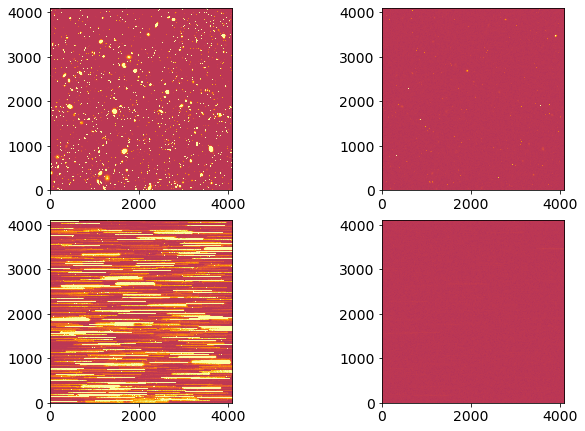

In [14]:
### Show them!

ncols = 2

all = [direct,new_direct,slitless,new_slitless]
print(all)

#N = len(all)
# not sure why this isn't working
#nrows = -(-N/ncols) # returns ceiling of division
#print(nrows)
nrows = 2

fig = plt.figure()

for i,a in enumerate(all):
    pf = pyfits.open(a)
    image = pf['SCI'].data
    print(np.mean(image),np.median(image),np.std(image))
    

    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.imshow(image, interpolation='Nearest', 
              origin='lower', cmap='inferno',
              vmin=-1,vmax=1)
    #ax.scatter(primer['X_IMAGE'], primer['Y_IMAGE'], s=100,
    #               edgecolor='green', facecolor='none', alpha=0.7)

fig.tight_layout(pad=0.5)

## Show sources from primer catalogs

0.28607887 0.0 3.9518452


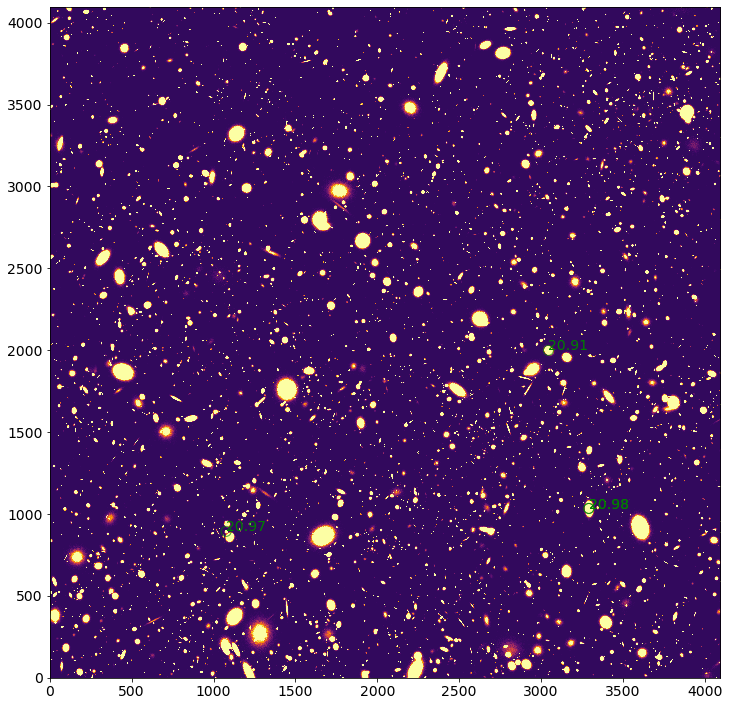

In [15]:
fig = plt.figure(figsize=(10,10))

pf = pyfits.open(direct)
image = pf['SCI'].data
print(np.mean(image),np.median(image),np.std(image))

#filt = primer['MAG'] < 20
filt = (primer['MAG'] > 20.9) & (primer['MAG'] < 21)

    

ax = fig.add_subplot(111)
ax.imshow(image, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.5, cmap='inferno')
ax.scatter(primer['X_IMAGE'][filt], primer['Y_IMAGE'][filt], s=100,
            edgecolor='green', facecolor='none', alpha=0.7)
for i in range(len(primer[filt])):
    ax.text(primer[filt]['X_IMAGE'][i], primer[filt]['Y_IMAGE'][i],"%.2f" % (primer[filt]['MAG'][i]),c="green")

fig.tight_layout(pad=0.5)

In [ ]:
primer[filt]['NUMBER','RA','DEC','MAG'].show_in_notebook()

In [ ]:
# Random
# 23961 10.0011107466  0.0149484929 18.49
# 8063  10.0412372492  0.0029643496 19.87
# 8990  10.005562076  -0.0566183098 20.79
# 606    9.9664018228 -0.0055298638 20.91 continuum
# 23115  9.958860925  -0.0350264133 20.98
# 2388  10.0098736134 -0.0298934341 21.95
# 21289  9.9912782697 -0.0334312864 22.92
# 12314 10.0110716308  0.05128653   23.97

## Find sources in the direct image
[top](#Table-of-Contents)

Just like the multi-mission, I am using SExtractor to find all of the sources in the direct images. This step is important not only for finding the sources but also for generating the segmentation map which will be used during the extraction of the spectra.

I may eventually adapt this to use SEP just like Grizli, but currently I understand SExtractor a little better.

The re-run the previous step, run this command.  In case you want to change the SExtractor parameters.

In [16]:
# remove segmentation FITS to redo "next" step
!rm *_seg.fits

In [17]:
print(new_direct)

Roman_ptg01_WFI_G150_random_direct_final_v1.fits


In [18]:
## Make SExtractor catalog

mag_zero = 25.91

#for direct in direct_files:
for direct in [new_direct]:

    prefix = direct.replace(".fits","")
    
    sex = "Roman.sex"
             
    cat = prefix + ".cat"   
    seg = prefix + "_seg.fits"
    bkg = prefix + "_bkg.fits"
    #aper = prefix + "_aper.fits"
    
    if not os.path.exists(seg):
        #os.system('wget http://www.stsci.edu/~brammer/grism/grizli_xdf_sextractor.tar.gz')
        #os.system('tar xzvf grizli_xdf_sextractor.tar.gz')
        
        #sex = prefix + ".sex"
        
        
        wht = direct + "[2]"
        direct_ext = direct + "[1]"
        
        checkimage_name = seg + "," + bkg
        #checkimage_name = seg + "," + bkg + "," + aper
        
        sex_str = 'sex ' + direct_ext + ' -c ' + sex + ' -WEIGHT_IMAGE ' + wht + \
                  ' -CHECKIMAGE_NAME ' + checkimage_name + ' -CATALOG_NAME ' + cat + \
                  ' -MAG_ZEROPOINT %.2f' % (mag_zero)
        os.system(sex_str)
        print(sex_str)

        #os.system('sex hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits ' + 
        #          '-c hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1.sex')
        

# awk '{ printf "circle(%f, %f, 0.00007) # text={%.3f}\n", $4, $5, $42 }' GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat > GRS_FOV1_roll0_dx0_dy0_SCA1_direct.reg
        

sex Roman_ptg01_WFI_G150_random_direct_final_v1.fits[1] -c Roman.sex -WEIGHT_IMAGE Roman_ptg01_WFI_G150_random_direct_final_v1.fits[2] -CHECKIMAGE_NAME Roman_ptg01_WFI_G150_random_direct_final_v1_seg.fits,Roman_ptg01_WFI_G150_random_direct_final_v1_bkg.fits -CATALOG_NAME Roman_ptg01_WFI_G150_random_direct_final_v1.cat -MAG_ZEROPOINT 25.91


This a temporary. Around here is where I would loop over all of the detectors. 

In [19]:
print(cat)

Roman_ptg01_WFI_G150_random_direct_final_v1.cat


## Check the pixel scale of the images

In [20]:
wcs_pixel_scale(direct)
wcs_pixel_scale(slitless)

Filename: Roman_ptg01_WFI_G150_random_direct_final_v1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float64   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float64   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
cdelt1 = 0.1100 "/pixel
cdelt2 = -0.1100 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

Filename: Roman_ptg01_WFI_G150_random_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
cdelt1 = 0.1100 "/pixel
cdelt2 = -0.1100 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg



## Read SExtractor Photometry of Direct Images
[top](#Table-of-Contents)

In [21]:
print(cat)
phot = Table.read(cat, format='ascii.sextractor') # ref_cat in multimission
print(len(phot))

Roman_ptg01_WFI_G150_random_direct_final_v1.cat
9699


In [22]:
filt = (phot['MAG_AUTO'] > 24) & (phot['MAG_AUTO'] < 25)
phot['NUMBER','X_WORLD','Y_WORLD','MAG_AUTO'][filt].show_in_notebook()



# random
ids = [4986, 3413, 2182, 387, 2349]
#print(phot["NUMBER"] == ids)

[phot[phot["NUMBER"] == id]['X_WORLD','Y_WORLD'].copy() for id in ids]
#print(phot['X_WORLD','Y_WORLD'][ids])


#id = phot['NUMBER'][np.argmin(dr)]
#obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
#print('ID:%d, mag=%.2f' %(id, obj_mag))

[<Table length=1>
   X_WORLD        Y_WORLD    
     deg            deg      
   float64        float64    
 ------------ ---------------
 9.9833372373 -0.013670032601,
 <Table length=1>
   X_WORLD        Y_WORLD    
     deg            deg      
   float64        float64    
 ------------ ---------------
 9.9907606728 0.0054266297234,
 <Table length=1>
   X_WORLD       Y_WORLD    
     deg           deg      
   float64       float64    
 ------------ --------------
 9.9455771439 0.022487195196,
 <Table length=1>
   X_WORLD       Y_WORLD    
     deg           deg      
   float64       float64    
 ----------- ---------------
 9.935157912 -0.066465043988,
 <Table length=1>
   X_WORLD       Y_WORLD    
     deg           deg      
   float64       float64    
 ------------ --------------
 10.008285571 0.019515925018]

17.8499 99.0


(10.0, 32.0)

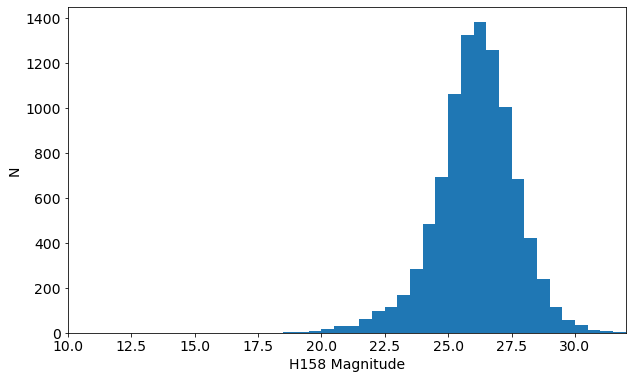

In [23]:
print(np.min(phot["MAG_AUTO"]),np.max(phot["MAG_AUTO"]))

fig = plt.figure()
p = fig.add_subplot(111)
p.hist(phot["MAG_AUTO"],range=(10,32),bins=44)
p.set_xlabel("H158 Magnitude")
p.set_ylabel("N")
p.set_xlim(10,32)

## (TESTING) Fake segmentation image - SKIP

In [ ]:
# create fake segmentation

yl, xl = 4088, 4088
#seg = np.zeros((yl, xl))

id = 6572
#r0, d0 = 53.2356312, -27.8250528 # emission line object?
x0, y0 = 1208.681132551118, 1574.86233818024
r = 45 # pixels

seg_img = create_circular_mask(yl,xl,[x0,y0],r)*id
print(seg_img)

seg = "seg.fits"
hdu = pyfits.PrimaryHDU(seg_img,header=head)
#hdu.verify('warn')''
hdu.writeto(seg,clobber=True)

In [ ]:
# display segmentation
ext = 0
pf = pyfits.open(seg)
seg_img = pf[ext].data


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(seg_img)

In [ ]:
phot = phot[phot["NUMBER"] == id]
print(phot)

## Roman object simulation
[top](#Table-of-Contents)

In [24]:
### Roman GRS grism
# allow simulation of objects at the edges
#pad=0 # pixels
pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

# using the ZP Anihita gave me for the direct image

# sims              old  new 
#mag_limit = 18 #    34   11
#mag_limit = 20 #   273   49
#mag_limit = 22 #  1599  334 
#mag_limit = 24 #  5177 1830
#mag_limit = 26 # 10015 5704
#mag_limit = 28 #       7172
mag_limit = 30 

#h, wcs = grizli.fake_image.wfirst_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(2048,2048))
#grizli.fake_image.make_fake_image(h, output='wfirst.fits', exptime=EXPTIME, nexp=NEXP)

Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                              ref_file=new_direct, ref_ext=1,
                              seg_file=seg, shrink_segimage=True)

Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
Roman.catalog = Roman_cat

mask = Roman_cat['MAG_AUTO'] < mag_limit
print('N=%d' %(mask.sum()))
#Roman.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
#Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask], verbose=True)

Roman_ptg01_WFI_G150_random_direct_final_v1.fits
Roman_ptg01_WFI_G150_random_direct_final_v1.fits[0]
Image cutout: x=slice(0, 4096, None), y=slice(0, 4096, None) [Out of range]
Roman_ptg01_WFI_G150_random_slitless_final_v1.fits / blot reference Roman_ptg01_WFI_G150_random_direct_final_v1.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4096, None), y=slice(0, 4096, None) [Out of range]
Roman_ptg01_WFI_G150_random_slitless_final_v1.fits / Pad ref HDU with 1650 pixels
Roman_ptg01_WFI_G150_random_slitless_final_v1.fits / blot segmentation Roman_ptg01_WFI_G150_random_direct_final_v1_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=9538
ID 9495 not found in segmentation image


## (TESTING) Roman pad and magnitude test - SKIP

In [ ]:
### Roman GRS grism

# test set
#pads = [0]
#mag_limits = [18,20]

pads = [0,100,200,400,800]
mag_limits = [18,20,22,24,26]

info_list = []
cat_list = []
i = 0 # iter
N = len(pads) * len(mag_limits) # total iter

for pad in pads:
    for mag_limit in mag_limits:

        Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                                      ref_file=new_direct, ref_ext=1,
                                      seg_file=seg, shrink_segimage=True)

        Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
        Roman.catalog = Roman_cat

        mask = Roman_cat['MAG_AUTO'] < mag_limit
        Ntot = mask.sum()
        
        Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
        
        ids_ext = []
        for id in Roman.object_dispersers:
            is_cgs, spectrum_1d, beam = Roman.object_dispersers[id]
            if len(beam) > 0: 
                ids_ext.append(id)
        
        ids_ext = np.array(ids_ext)
        Next = len(ids_ext)
        
        print()
        print('iter = %i of %i' % (i+1,N))
        print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
        print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))
        print("\n")
        
        info_list.append([pad, mag_limit, Ntot, Next])
        
        extract_cat = Roman.catalog[ids_ext - 1] 
        cat_list.append(extract_cat)
        
        fig = plt.figure(figsize=[20,10])
        # Direct
        ax1 = fig.add_subplot(121)
        ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='viridis')
        ax1.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
                   edgecolor='white', facecolor='none', alpha=0.7)
        ax1.set_xticklabels([])
        ax1.set_title('pad=%d  mag_limit=%d  Ntot=%d  Next=%d' %(pad,mag_limit,Ntot,Next))

        # Grism
        ax2 = fig.add_subplot(122)
        ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='gray_r')
        ax2.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
                   edgecolor='green', facecolor='none', alpha=0.7)
        ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
        fig.tight_layout(pad=4.0)   
        
        i += 1
        
#print(info_list)


print("\n\n")
print("#"*12)
print("Test summary")
print("#"*12)
print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
for info in info_list:
    pad, mag_limit, Ntot, Next = info
    print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))

print()
print(len(cat_list))
#print(cat_list)

## Check simulation
[top](#Table-of-Contents)

Possible problem with the aXeSIM conf file.  This function checks if the OrderDict exists within GrismFLT class.

In [25]:
all_cat,magcut_cat,extract_cat = check_sims(Roman, mag_limit)

All sources   = 9699
Magnitude cut = 9538
Simulated     = 9537



In [26]:
Roman.catalog[:20].show_in_notebook()

In [ ]:
#wcs = pywcs.WCS(head)

## Show direct images and slitless spectra
[top](#Table-of-Contents)

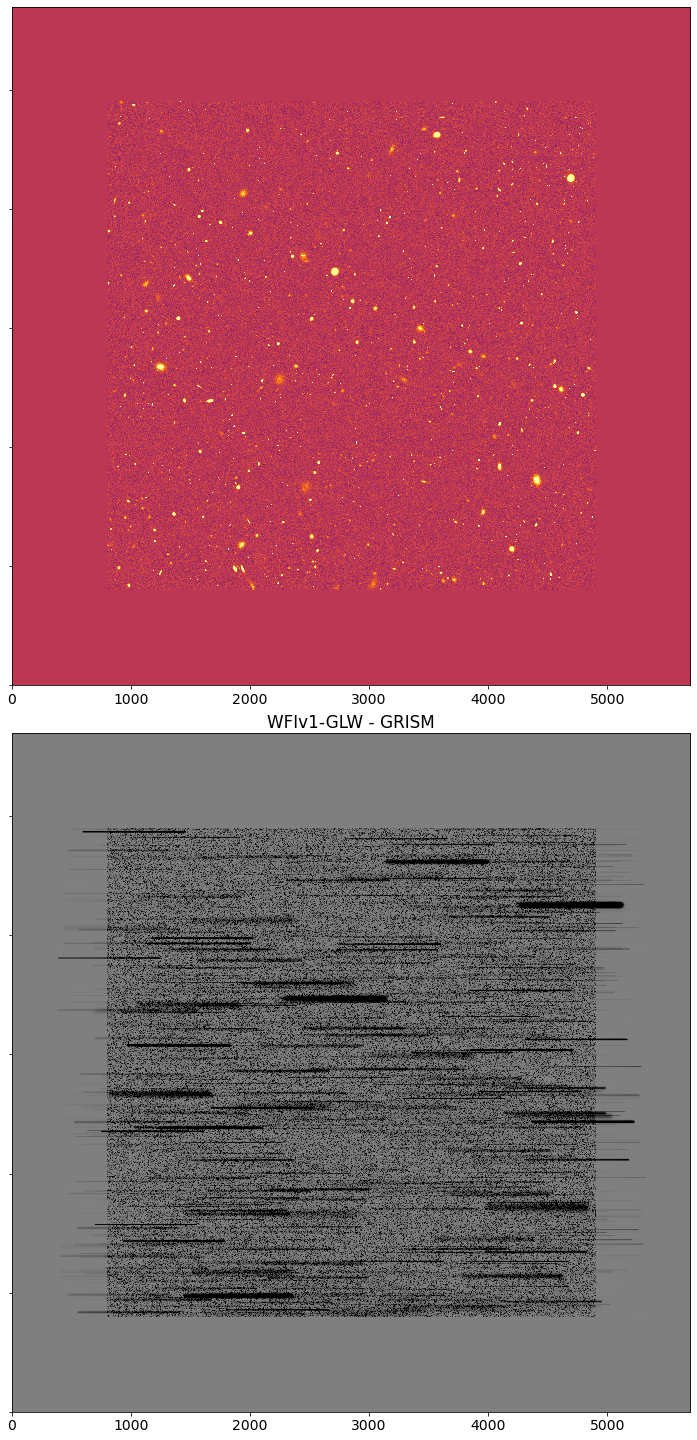

In [27]:
### Show them!

fig = plt.figure(figsize=[10,20])
# Direct
axt = fig.add_subplot(211)
axt.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.1, cmap='inferno')
# Grism
axb = fig.add_subplot(212)
axb.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', cmap='gray_r', vmin=-0.02, vmax=0.02)
axb.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
    

axt.set_yticklabels([])
axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

## Show direct images and slitless spectra (with sources overplotted)

This is a check to see if there is a field dependence (or magnitude) to the failed simulations.

(-0.5, 5695.5)
(-0.5, 5695.5)
(-0.5, 5695.5)
(-0.5, 5695.5)


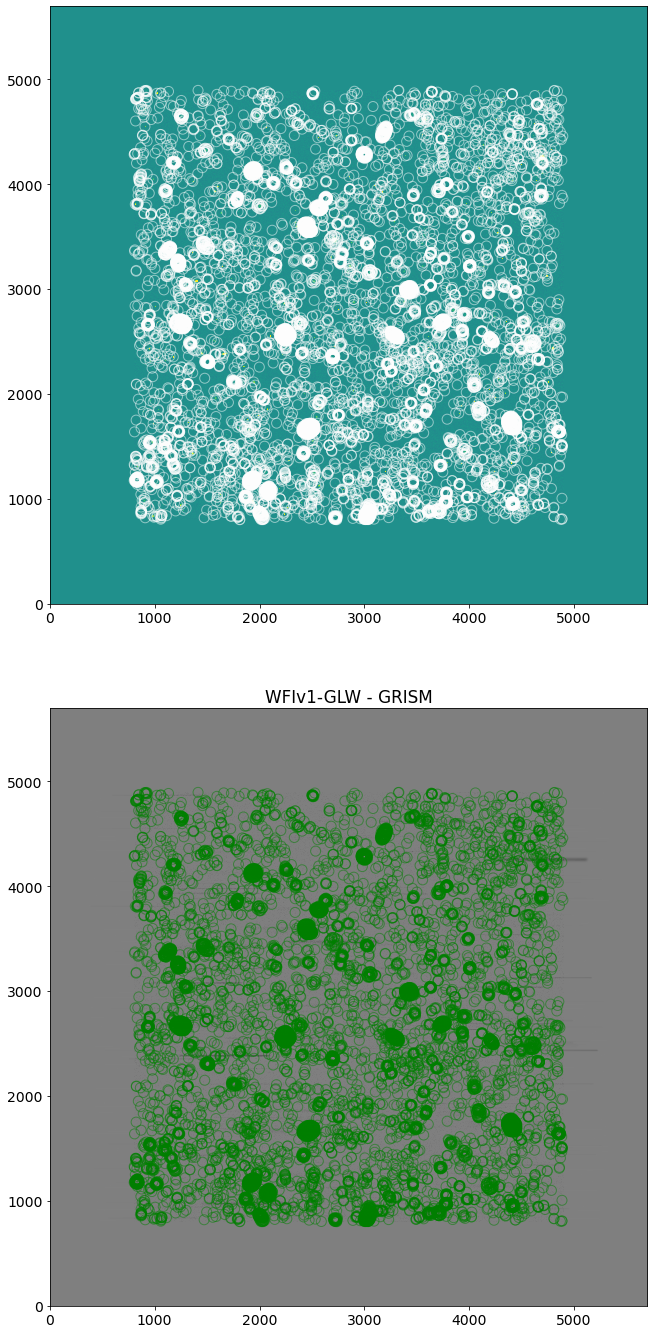

In [28]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,20])

#extract_cat = Roman.catalog[0][0]

# Direct
#ax1 = fig.add_subplot(211, projection=wcs)
ax1 = fig.add_subplot(211)
ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='viridis')

ax1.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
           edgecolor='white', facecolor='none', alpha=0.5)

#ax1.set_xticklabels([])
print(ax1.get_xlim())
print(ax1.get_ylim())
    
# Grism
#ax2 = fig.add_subplot(212, projection=wcs)
ax2 = fig.add_subplot(212)
ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='gray_r')

ax2.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
           edgecolor='green', facecolor='none', alpha=0.5)


ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
print(ax2.get_xlim())
print(ax2.get_ylim())

fig.tight_layout(pad=4.0)

In [ ]:
print(phot.colnames)
print(phot["X_WORLD","Y_WORLD"])
print(phot["MAG_AUTO"])

## (TESTING) Filter catalog based on position on the detector and magnitude - SKIP

In [ ]:
# OLD - DO NOT RUN!

cat = Roman.catalog
cat["NUMBER","MAG_AUTO","id","ra","dec","x_flt","y_flt"]
#cat.colnames

x_filt = (cat['x_flt'] > 2400) & (cat['x_flt'] < 2600)
y_filt = (cat['y_flt'] > 3900) & (cat['y_flt'] < 4100)
mag_filt = (cat['MAG_AUTO'] < 24)

filt = x_filt & y_filt & mag_filt

print(cat[filt]['MAG_AUTO','id',"ra","dec","x_flt","y_flt"])

## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
from importlib import reload
reload(grizli.model)

## Loop over all objects and fit their redshifts
[top](#Table-of-Contents)

In [29]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

In [32]:
# Test 
Nl = [id for id in phot['NUMBER']][:10]

# All sources
#Nl = [id for id in phot['NUMBER']]

# Problem, might need try/except in fitting

1
beam__00001.grism.A_GLW.fits
my_roman_sims_00001.beams.fits
load_master_fits: my_roman_sims_00001.beams.fits
1 Roman_ptg01_WFI_G150_random_slitless_final_v1.fits GRISM
User templates! N=16 

  0.0500   18254.1 (0.0500) 1/335
  0.0542   18231.9 (0.0542) 2/335
  0.0584   18207.7 (0.0584) 3/335
  0.0627   18181.1 (0.0627) 4/335
  0.0669   18150.6 (0.0669) 5/335
  0.0712   18118.5 (0.0712) 6/335
  0.0755   18088.6 (0.0755) 7/335
  0.0798   18060.4 (0.0798) 8/335
  0.0841   18029.9 (0.0841) 9/335
  0.0885   17997.0 (0.0885) 10/335
  0.0929   17962.3 (0.0929) 11/335
  0.0972   17926.2 (0.0972) 12/335
  0.1016   17891.5 (0.1016) 13/335
  0.1060   17862.4 (0.1060) 14/335
  0.1105   17840.8 (0.1105) 15/335
  0.1149   17824.1 (0.1149) 16/335
  0.1194   17810.1 (0.1194) 17/335
  0.1239   17796.0 (0.1239) 18/335
  0.1284   17777.3 (0.1284) 19/335
  0.1329   17758.1 (0.1329) 20/335
  0.1375   17744.2 (0.1375) 21/335
  0.1420   17732.2 (0.1420) 22/335
  0.1466   17723.5 (0.1466) 23/335
  0.1512   

- 2.7801   16144.2 (2.7801) 1/21
- 2.7803   16142.7 (2.7803) 2/21
- 2.7805   16141.4 (2.7805) 3/21
- 2.7807   16140.2 (2.7807) 4/21
- 2.7809   16139.2 (2.7809) 5/21
- 2.7811   16138.4 (2.7811) 6/21
- 2.7813   16137.6 (2.7813) 7/21
- 2.7815   16137.1 (2.7815) 8/21
- 2.7817   16136.7 (2.7817) 9/21
- 2.7819   16136.5 (2.7819) 10/21
- 2.7821   16136.5 (2.7821) 11/21
- 2.7823   16136.6 (2.7821) 12/21
- 2.7825   16136.9 (2.7821) 13/21
- 2.7827   16137.3 (2.7821) 14/21
- 2.7829   16137.9 (2.7821) 15/21
- 2.7831   16138.6 (2.7821) 16/21
- 2.7833   16139.5 (2.7821) 17/21
- 2.7835   16140.5 (2.7821) 18/21
- 2.7837   16141.7 (2.7821) 19/21
- 2.7839   16142.9 (2.7821) 20/21
- 2.7841   16144.3 (2.7821) 21/21
Drizzle line -> OIII (25.19 0.94)
Drizzle line -> Hb   (-10.00 1.81)
Drizzle line -> OIII-4363 (-5.41 2.14)
Drizzle line -> Hg   (-1.57 2.14)
Drizzle line -> Hd   (-5.55 1.95)
Drizzle line -> H7   (-2.83 1.95)
Drizzle line -> H8   (-2.87 2.31)
Drizzle line -> H9   (2.65 1.99)
Drizzle line -> H1

  1.8427   23564.6 (1.8427) 7/41
  1.8455   23561.6 (1.8455) 8/41
  1.8484   23561.8 (1.8455) 9/41
  1.8512   23561.8 (1.8455) 10/41
  1.8541   23567.0 (1.8455) 11/41
  1.8569   23574.9 (1.8455) 12/41
  1.8598   23577.7 (1.8455) 13/41
  1.8626   23575.8 (1.8455) 14/41
  1.8655   23569.6 (1.8455) 15/41
  1.8684   23557.8 (1.8684) 16/41
  1.8712   23541.4 (1.8712) 17/41
  1.8741   23526.0 (1.8741) 18/41
  1.8770   23512.3 (1.8770) 19/41
  1.8799   23502.4 (1.8799) 20/41
  1.8828   23498.3 (1.8828) 21/41
  1.8856   23501.9 (1.8828) 22/41
  1.8885   23509.7 (1.8828) 23/41
  1.8914   23521.9 (1.8828) 24/41
  1.8943   23538.4 (1.8828) 25/41
  1.8972   23557.6 (1.8828) 26/41
  1.9001   23587.4 (1.8828) 27/41
  1.9030   23627.6 (1.8828) 28/41
  1.9059   23671.9 (1.8828) 29/41
  1.9088   23717.8 (1.8828) 30/41
  1.9117   23776.9 (1.8828) 31/41
  1.9146   23842.1 (1.8828) 32/41
  1.9176   23905.1 (1.8828) 33/41
  1.9205   23968.9 (1.8828) 34/41
  1.9234   24028.6 (1.8828) 35/41
  1.9263   24081.

- 1.6893   25335.3 (1.6879) 52/81
- 1.6895   25335.9 (1.6879) 53/81
- 1.6897   25336.7 (1.6879) 54/81
- 1.6899   25337.7 (1.6879) 55/81
- 1.6901   25338.7 (1.6879) 56/81
- 1.6903   25339.9 (1.6879) 57/81
- 1.6905   25341.2 (1.6879) 58/81
- 1.6907   25342.5 (1.6879) 59/81
- 1.6909   25344.0 (1.6879) 60/81
- 1.6911   25345.7 (1.6879) 61/81
- 1.6913   25347.4 (1.6879) 62/81
- 1.6915   25349.3 (1.6879) 63/81
- 1.6917   25351.2 (1.6879) 64/81
- 1.6919   25353.1 (1.6879) 65/81
- 1.6921   25355.0 (1.6879) 66/81
- 1.6923   25356.9 (1.6879) 67/81
- 1.6925   25358.8 (1.6879) 68/81
- 1.6927   25360.7 (1.6879) 69/81
- 1.6929   25362.7 (1.6879) 70/81
- 1.6931   25364.8 (1.6879) 71/81
- 1.6933   25366.8 (1.6879) 72/81
- 1.6935   25368.8 (1.6879) 73/81
- 1.6937   25370.8 (1.6879) 74/81
- 1.6939   25372.7 (1.6879) 75/81
- 1.6941   25374.7 (1.6879) 76/81
- 1.6943   25376.8 (1.6879) 77/81
- 1.6945   25379.1 (1.6879) 78/81
- 1.6947   25381.6 (1.6879) 79/81
- 1.6949   25384.2 (1.6879) 80/81
- 1.6951   253

- 2.2650    1004.4 (2.2646) 13/243
- 2.2652    1004.4 (2.2646) 14/243
- 2.2654    1004.5 (2.2646) 15/243
- 2.2656    1004.5 (2.2646) 16/243
- 2.2658    1004.6 (2.2646) 17/243
- 2.2660    1004.6 (2.2646) 18/243
- 2.2662    1004.5 (2.2646) 19/243
- 2.2664    1004.2 (2.2664) 20/243
- 2.2666    1003.9 (2.2666) 21/243
- 2.2668    1003.4 (2.2668) 22/243
- 2.2670    1002.8 (2.2670) 23/243
- 2.2672    1002.1 (2.2672) 24/243
- 2.2674    1001.4 (2.2674) 25/243
- 2.2676    1000.5 (2.2676) 26/243
- 2.2678     999.7 (2.2678) 27/243
- 2.2680     998.9 (2.2680) 28/243
- 2.2682     998.2 (2.2682) 29/243
- 2.2684     997.6 (2.2684) 30/243
- 2.2686     997.2 (2.2686) 31/243
- 2.2688     996.9 (2.2688) 32/243
- 2.2690     996.8 (2.2690) 33/243
- 2.2692     996.8 (2.2692) 34/243
- 2.2694     996.8 (2.2692) 35/243
- 2.2696     997.0 (2.2692) 36/243
- 2.2698     997.2 (2.2692) 37/243
- 2.2700     997.6 (2.2692) 38/243
- 2.2702     998.0 (2.2692) 39/243
- 2.2704     998.4 (2.2692) 40/243
- 2.2706     999.0 (

- 1.9666    1005.5 (2.2692) 243/243
User templates! N=16 

  2.2037    1006.3 (2.2037) 1/41
  2.2070    1007.5 (2.2037) 2/41
  2.2102    1009.5 (2.2037) 3/41
  2.2134    1009.6 (2.2037) 4/41
  2.2166    1009.0 (2.2037) 5/41
  2.2198    1007.1 (2.2037) 6/41
  2.2230    1005.6 (2.2230) 7/41
  2.2263    1009.9 (2.2230) 8/41
  2.2295    1010.4 (2.2230) 9/41
  2.2327    1008.0 (2.2230) 10/41
  2.2359    1003.7 (2.2359) 11/41
  2.2392    1009.3 (2.2359) 12/41
  2.2424    1009.5 (2.2359) 13/41
  2.2457    1009.9 (2.2359) 14/41
  2.2489    1007.5 (2.2359) 15/41
  2.2522    1005.4 (2.2359) 16/41
  2.2554    1007.3 (2.2359) 17/41
  2.2587    1010.2 (2.2359) 18/41
  2.2619    1007.2 (2.2359) 19/41
  2.2652    1004.4 (2.2359) 20/41
  2.2685     997.4 (2.2685) 21/41
  2.2717    1003.8 (2.2685) 22/41
  2.2750    1009.0 (2.2685) 23/41
  2.2783    1009.8 (2.2685) 24/41
  2.2816    1009.2 (2.2685) 25/41
  2.2849    1005.4 (2.2685) 26/41
  2.2881    1004.0 (2.2685) 27/41
  2.2914    1004.9 (2.2685) 28/4

- 2.8284    2763.7 (2.8284) 2/243
- 2.8286    2763.6 (2.8286) 3/243
- 2.8288    2763.4 (2.8288) 4/243
- 2.8290    2763.4 (2.8290) 5/243
- 2.8292    2763.3 (2.8292) 6/243
- 2.8294    2763.3 (2.8294) 7/243
- 2.8296    2763.2 (2.8296) 8/243
- 2.8298    2763.2 (2.8298) 9/243
- 2.8300    2763.1 (2.8300) 10/243
- 2.8302    2763.0 (2.8302) 11/243
- 2.8304    2762.9 (2.8304) 12/243
- 2.8306    2762.7 (2.8306) 13/243
- 2.8308    2762.6 (2.8308) 14/243
- 2.8310    2762.5 (2.8310) 15/243
- 2.8312    2762.5 (2.8310) 16/243
- 2.8314    2762.7 (2.8310) 17/243
- 2.8316    2763.0 (2.8310) 18/243
- 2.8318    2763.4 (2.8310) 19/243
- 2.8320    2764.0 (2.8310) 20/243
- 2.8322    2764.5 (2.8310) 21/243
- 2.8324    2765.0 (2.8310) 22/243
- 2.8326    2765.3 (2.8310) 23/243
- 2.8328    2765.6 (2.8310) 24/243
- 2.8330    2765.7 (2.8310) 25/243
- 2.8332    2765.8 (2.8310) 26/243
- 2.8334    2765.7 (2.8310) 27/243
- 2.8336    2765.5 (2.8310) 28/243
- 2.8338    2765.2 (2.8310) 29/243
- 2.8340    2764.8 (2.8310) 

  0.5602    3850.7 (0.4870) 100/335
  0.5664    3850.9 (0.4870) 101/335
  0.5727    3850.9 (0.4870) 102/335
  0.5790    3850.8 (0.4870) 103/335
  0.5853    3851.0 (0.4870) 104/335
  0.5917    3851.0 (0.4870) 105/335
  0.5981    3851.0 (0.4870) 106/335
  0.6045    3851.0 (0.4870) 107/335
  0.6109    3851.0 (0.4870) 108/335
  0.6174    3851.1 (0.4870) 109/335
  0.6238    3851.1 (0.4870) 110/335
  0.6303    3851.1 (0.4870) 111/335
  0.6369    3851.1 (0.4870) 112/335
  0.6434    3851.1 (0.4870) 113/335
  0.6500    3850.3 (0.4870) 114/335
  0.6566    3850.9 (0.4870) 115/335
  0.6633    3850.9 (0.4870) 116/335
  0.6699    3851.1 (0.4870) 117/335
  0.6766    3851.1 (0.4870) 118/335
  0.6834    3851.1 (0.4870) 119/335
  0.6901    3851.1 (0.4870) 120/335
  0.6969    3850.4 (0.4870) 121/335
  0.7037    3851.0 (0.4870) 122/335
  0.7105    3851.1 (0.4870) 123/335
  0.7174    3850.5 (0.4870) 124/335
  0.7242    3849.3 (0.4870) 125/335
  0.7312    3850.1 (0.4870) 126/335
  0.7381    3850.6 (0.4870) 

- 1.9128    3841.2 (1.9092) 221/243
- 1.9130    3841.6 (1.9092) 222/243
- 1.9132    3841.9 (1.9092) 223/243
- 1.9134    3842.3 (1.9092) 224/243
- 1.9136    3842.8 (1.9092) 225/243
- 1.9138    3843.2 (1.9092) 226/243
- 1.9140    3843.6 (1.9092) 227/243
- 1.9142    3844.1 (1.9092) 228/243
- 1.9144    3844.5 (1.9092) 229/243
- 1.9146    3845.0 (1.9092) 230/243
- 1.9148    3845.4 (1.9092) 231/243
- 1.9150    3845.7 (1.9092) 232/243
- 1.9152    3846.1 (1.9092) 233/243
- 1.9154    3846.3 (1.9092) 234/243
- 1.9156    3846.6 (1.9092) 235/243
- 1.9158    3846.7 (1.9092) 236/243
- 1.9160    3846.9 (1.9092) 237/243
- 1.9162    3847.0 (1.9092) 238/243
- 1.9164    3847.0 (1.9092) 239/243
- 1.9166    3847.1 (1.9092) 240/243
- 1.9168    3847.1 (1.9092) 241/243
- 1.9170    3847.1 (1.9092) 242/243
- 1.9172    3847.1 (1.9092) 243/243
User templates! N=16 

  1.8510    3848.4 (1.8510) 1/41
  1.8538    3848.4 (1.8510) 2/41
  1.8567    3848.5 (1.8510) 3/41
  1.8595    3848.5 (1.8510) 4/41
  1.8624    3848.

- 2.8039    1531.7 (2.8039) 21/243
- 2.8041    1531.5 (2.8041) 22/243
- 2.8043    1531.2 (2.8043) 23/243
- 2.8045    1531.0 (2.8045) 24/243
- 2.8047    1530.7 (2.8047) 25/243
- 2.8049    1530.4 (2.8049) 26/243
- 2.8051    1530.2 (2.8051) 27/243
- 2.8053    1530.0 (2.8053) 28/243
- 2.8055    1529.8 (2.8055) 29/243
- 2.8057    1529.8 (2.8057) 30/243
- 2.8059    1529.7 (2.8059) 31/243
- 2.8061    1529.8 (2.8059) 32/243
- 2.8063    1529.9 (2.8059) 33/243
- 2.8065    1530.1 (2.8059) 34/243
- 2.8067    1530.3 (2.8059) 35/243
- 2.8069    1530.5 (2.8059) 36/243
- 2.8071    1530.8 (2.8059) 37/243
- 2.8073    1531.1 (2.8059) 38/243
- 2.8075    1531.3 (2.8059) 39/243
- 2.8077    1531.6 (2.8059) 40/243
- 2.8079    1531.9 (2.8059) 41/243
- 2.8081    1532.1 (2.8059) 42/243
- 2.8083    1532.4 (2.8059) 43/243
- 2.8085    1532.6 (2.8059) 44/243
- 2.8087    1532.8 (2.8059) 45/243
- 2.8089    1533.0 (2.8059) 46/243
- 2.8091    1533.3 (2.8059) 47/243
- 2.8093    1533.5 (2.8059) 48/243
- 2.8095    1533.8 (

  0.8163    4141.4 (0.2928) 138/335
  0.8236    4141.4 (0.2928) 139/335
  0.8309    4141.0 (0.2928) 140/335
  0.8382    4140.0 (0.2928) 141/335
  0.8456    4141.4 (0.2928) 142/335
  0.8530    4141.3 (0.2928) 143/335
  0.8604    4141.2 (0.2928) 144/335
  0.8679    4141.3 (0.2928) 145/335
  0.8753    4140.5 (0.2928) 146/335
  0.8829    4139.9 (0.2928) 147/335
  0.8904    4139.1 (0.2928) 148/335
  0.8980    4137.6 (0.2928) 149/335
  0.9056    4133.4 (0.9056) 150/335
  0.9132    4136.8 (0.9056) 151/335
  0.9209    4141.0 (0.9056) 152/335
  0.9286    4141.3 (0.9056) 153/335
  0.9363    4140.2 (0.9056) 154/335
  0.9441    4141.5 (0.9056) 155/335
  0.9519    4141.4 (0.9056) 156/335
  0.9597    4140.2 (0.9056) 157/335
  0.9676    4137.8 (0.9056) 158/335
  0.9754    4140.0 (0.9056) 159/335
  0.9834    4141.5 (0.9056) 160/335
  0.9913    4141.0 (0.9056) 161/335
  0.9993    4137.4 (0.9056) 162/335
  1.0073    4140.4 (0.9056) 163/335
  1.0153    4141.1 (0.9056) 164/335
  1.0234    4141.1 (0.9056) 

  0.9032    4136.8 (0.9013) 17/41
  0.9051    4134.4 (0.9051) 18/41
  0.9070    4136.2 (0.9051) 19/41
  0.9090    4138.4 (0.9051) 20/41
  0.9109    4132.6 (0.9109) 21/41
  0.9128    4136.3 (0.9109) 22/41
  0.9147    4139.6 (0.9109) 23/41
  0.9166    4140.7 (0.9109) 24/41
  0.9185    4141.4 (0.9109) 25/41
  0.9204    4141.3 (0.9109) 26/41
  0.9224    4137.7 (0.9109) 27/41
  0.9243    4139.7 (0.9109) 28/41
  0.9262    4141.5 (0.9109) 29/41
  0.9281    4141.4 (0.9109) 30/41
  0.9301    4141.5 (0.9109) 31/41
  0.9320    4141.5 (0.9109) 32/41
  0.9339    4139.5 (0.9109) 33/41
  0.9359    4139.9 (0.9109) 34/41
  0.9378    4140.6 (0.9109) 35/41
  0.9397    4140.6 (0.9109) 36/41
  0.9417    4140.1 (0.9109) 37/41
  0.9436    4141.5 (0.9109) 38/41
  0.9456    4141.5 (0.9109) 39/41
  0.9475    4141.5 (0.9109) 40/41
  0.9495    4141.5 (0.9109) 41/41
First iteration: z_best=0.9109

- 0.9091    4138.2 (0.9091) 1/42
- 0.9093    4137.8 (0.9093) 2/42
- 0.9095    4137.2 (0.9095) 3/42
- 0.9097    4136.5 

- 2.2955    3183.2 (2.2955) 47/243
- 2.2957    3183.1 (2.2957) 48/243
- 2.2959    3183.1 (2.2957) 49/243
- 2.2961    3183.2 (2.2957) 50/243
- 2.2963    3183.4 (2.2957) 51/243
- 2.2965    3183.6 (2.2957) 52/243
- 2.2967    3184.0 (2.2957) 53/243
- 2.2969    3184.5 (2.2957) 54/243
- 2.2971    3185.0 (2.2957) 55/243
- 2.2973    3185.6 (2.2957) 56/243
- 2.2975    3186.2 (2.2957) 57/243
- 2.2977    3186.8 (2.2957) 58/243
- 2.2979    3187.3 (2.2957) 59/243
- 2.2981    3187.8 (2.2957) 60/243
- 2.2983    3188.2 (2.2957) 61/243
- 2.2985    3188.5 (2.2957) 62/243
- 2.2987    3188.7 (2.2957) 63/243
- 2.2989    3188.9 (2.2957) 64/243
- 2.2991    3189.1 (2.2957) 65/243
- 2.2993    3189.2 (2.2957) 66/243
- 2.2995    3189.3 (2.2957) 67/243
- 2.2997    3189.4 (2.2957) 68/243
- 2.2999    3189.4 (2.2957) 69/243
- 2.3001    3189.5 (2.2957) 70/243
- 2.3003    3189.5 (2.2957) 71/243
- 2.3005    3189.5 (2.2957) 72/243
- 2.3007    3189.6 (2.2957) 73/243
- 2.3009    3189.6 (2.2957) 74/243
- 2.3011    3189.7 (

  1.1832    4504.8 (0.3563) 184/335
  1.1919    4506.3 (0.3563) 185/335
  1.2007    4506.1 (0.3563) 186/335
  1.2096    4501.7 (0.3563) 187/335
  1.2184    4492.0 (0.3563) 188/335
  1.2273    4504.4 (0.3563) 189/335
  1.2362    4503.7 (0.3563) 190/335
  1.2452    4505.8 (0.3563) 191/335
  1.2542    4505.5 (0.3563) 192/335
  1.2632    4504.9 (0.3563) 193/335
  1.2723    4505.1 (0.3563) 194/335
  1.2814    4504.0 (0.3563) 195/335
  1.2905    4505.0 (0.3563) 196/335
  1.2997    4503.8 (0.3563) 197/335
  1.3089    4494.7 (0.3563) 198/335
  1.3182    4503.7 (0.3563) 199/335
  1.3275    4504.6 (0.3563) 200/335
  1.3368    4503.2 (0.3563) 201/335
  1.3462    4504.6 (0.3563) 202/335
  1.3556    4505.0 (0.3563) 203/335
  1.3650    4505.5 (0.3563) 204/335
  1.3745    4500.5 (0.3563) 205/335
  1.3840    4505.6 (0.3563) 206/335
  1.3936    4505.5 (0.3563) 207/335
  1.4032    4503.4 (0.3563) 208/335
  1.4128    4504.9 (0.3563) 209/335
  1.4225    4504.6 (0.3563) 210/335
  1.4322    4500.6 (0.3563) 

- 2.1291    4487.5 (2.1910) 24/63
- 2.1293    4486.8 (2.1910) 25/63
- 2.1295    4486.2 (2.1910) 26/63
- 2.1297    4485.7 (2.1910) 27/63
- 2.1299    4485.2 (2.1910) 28/63
- 2.1301    4484.9 (2.1910) 29/63
- 2.1303    4484.7 (2.1910) 30/63
- 2.1305    4484.5 (2.1910) 31/63
- 2.1307    4484.4 (2.1910) 32/63
- 2.1309    4484.4 (2.1910) 33/63
- 2.1311    4484.4 (2.1910) 34/63
- 2.1313    4484.4 (2.1910) 35/63
- 2.1315    4484.5 (2.1910) 36/63
- 2.1317    4484.6 (2.1910) 37/63
- 2.1319    4484.7 (2.1910) 38/63
- 2.1321    4485.0 (2.1910) 39/63
- 2.1323    4485.3 (2.1910) 40/63
- 2.1325    4485.7 (2.1910) 41/63
- 2.1327    4486.1 (2.1910) 42/63
- 2.1576    4487.5 (2.1910) 43/63
- 2.1578    4487.4 (2.1910) 44/63
- 2.1580    4487.3 (2.1910) 45/63
- 2.1582    4487.1 (2.1910) 46/63
- 2.1584    4487.0 (2.1910) 47/63
- 2.1586    4486.9 (2.1910) 48/63
- 2.1588    4486.7 (2.1910) 49/63
- 2.1590    4486.6 (2.1910) 50/63
- 2.1592    4486.5 (2.1910) 51/63
- 2.1594    4486.3 (2.1910) 52/63
- 2.1596    44

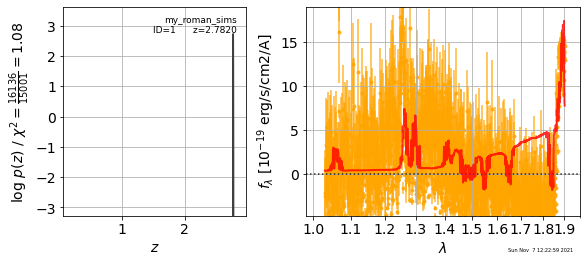

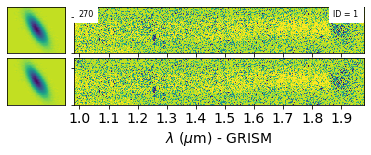

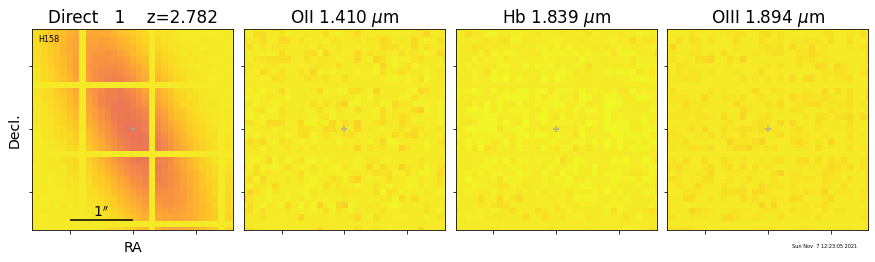

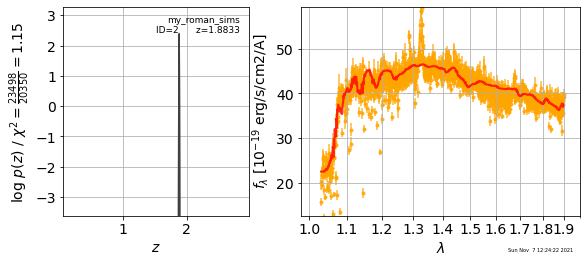

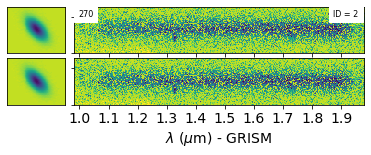

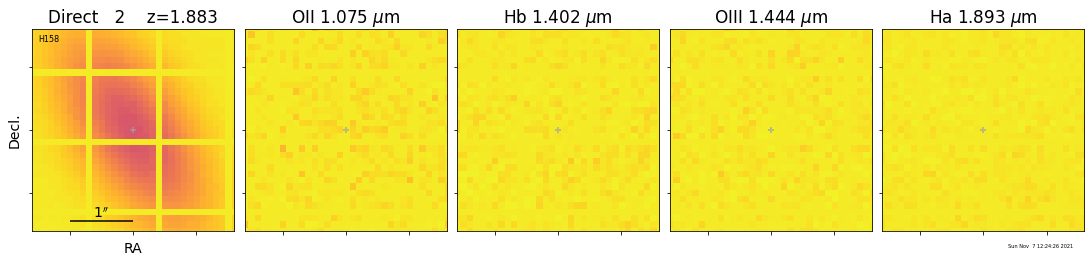

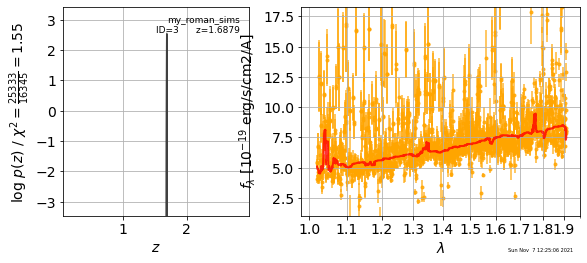

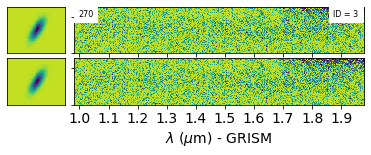

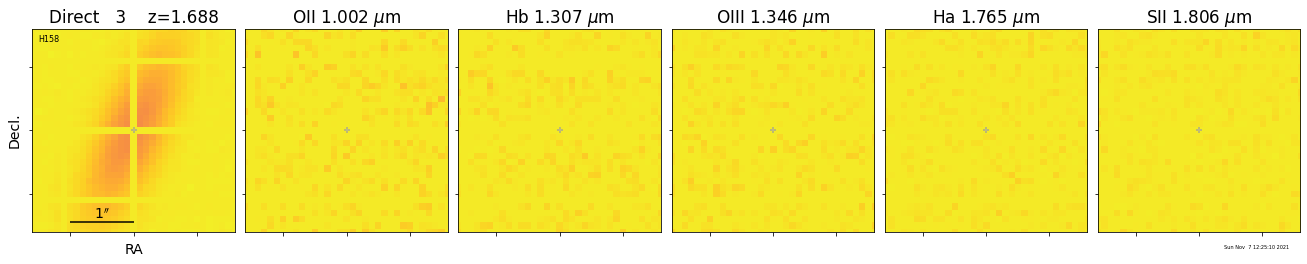

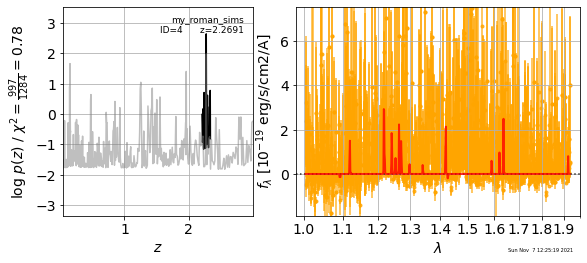

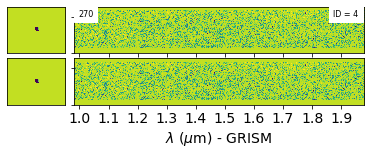

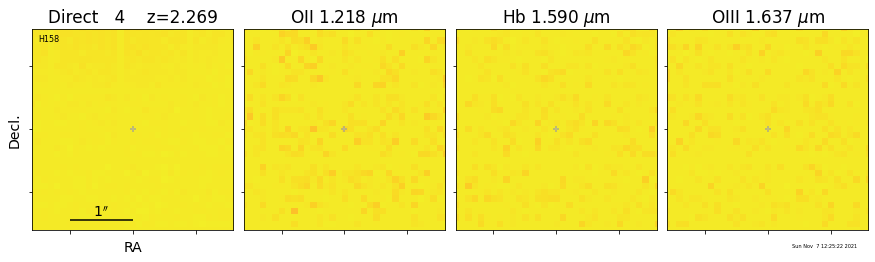

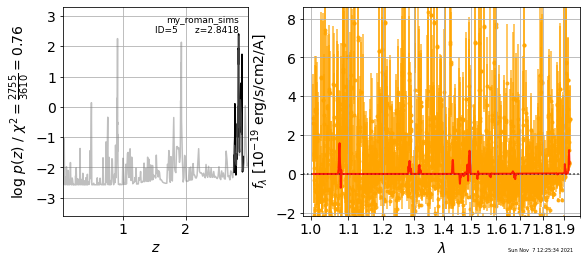

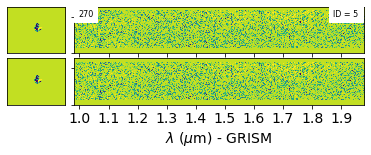

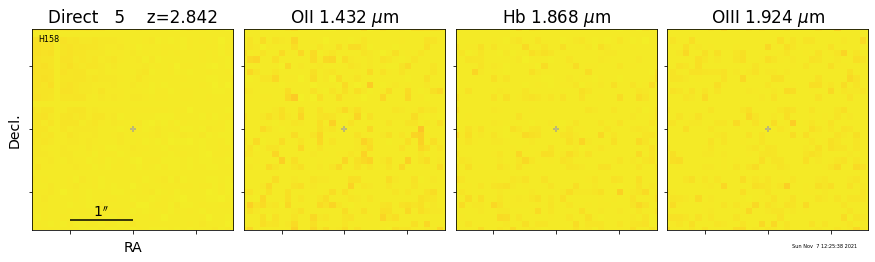

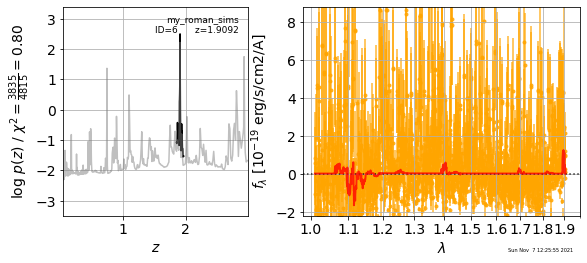

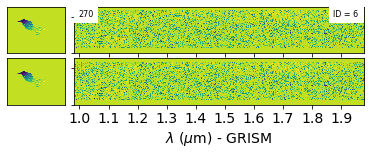

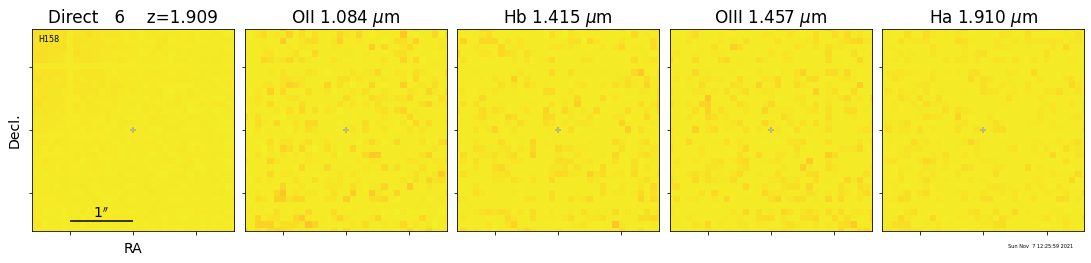

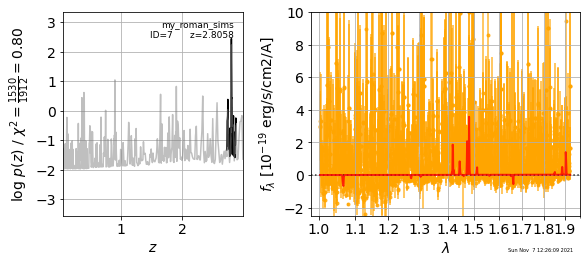

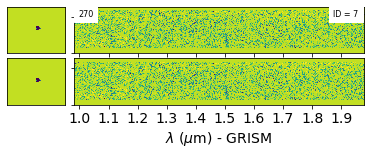

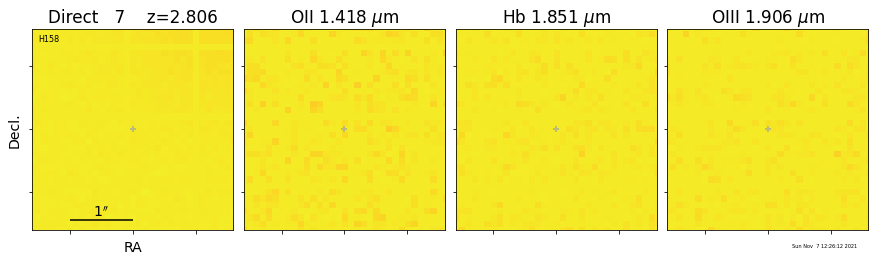

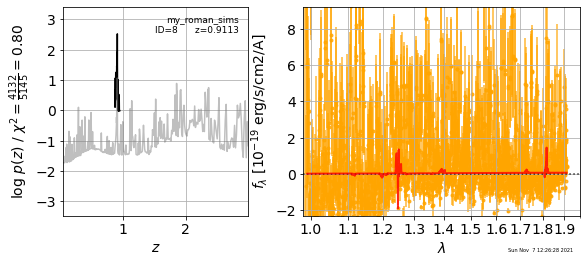

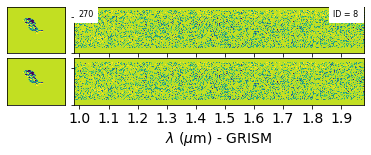

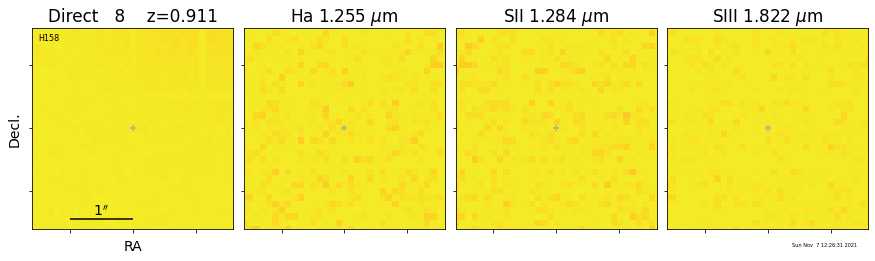

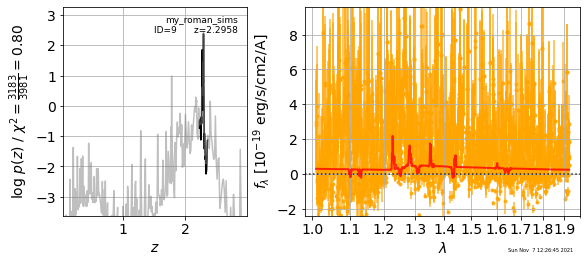

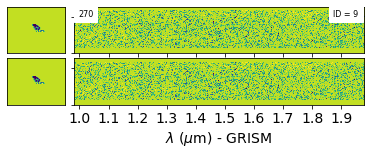

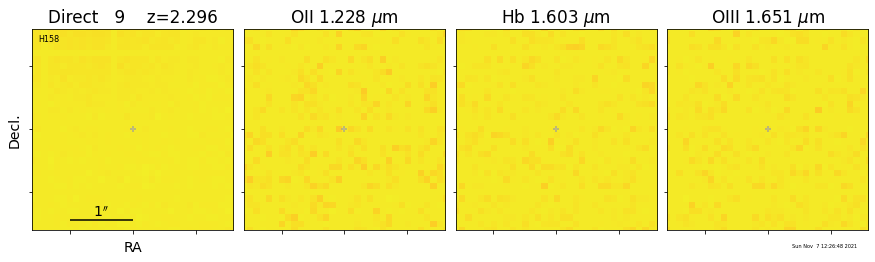

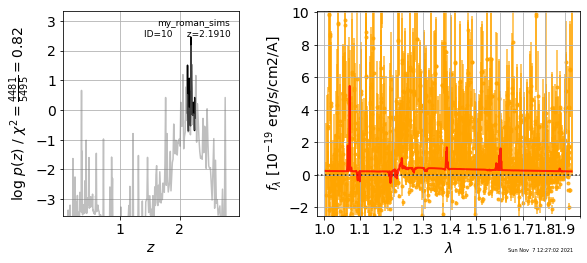

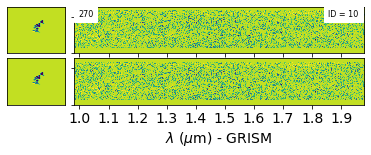

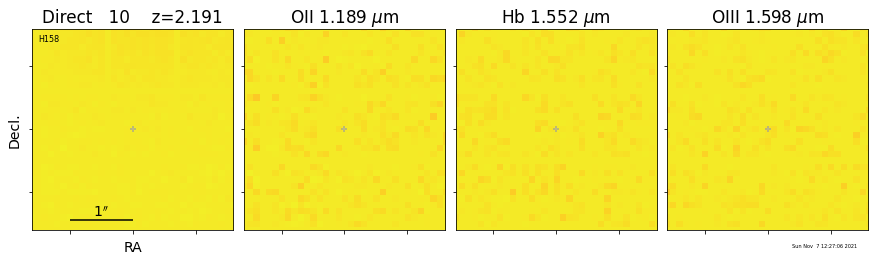

In [33]:
fwhm = 325 # km/s
t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# This breaks if there is a magnitude cut!!!
#for id in phot['NUMBER']:
for id in Nl:

    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

In [ ]:
print(type(Roman))

## Inspect Redshift Fitting Results
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

# Find ids of all the extracted objects
ids = []
files = glob.glob('*full.fits')
for file in files:
    #print(file)
    ids.append(int(file.replace(".full.fits","").split("_")[-1]))

#print(files)

ids.sort()
print(ids)
print("N =",len(ids))

In [ ]:
# ids of extracted objects sorted on magnitude
#new_ids = [pid for pid in phot["NUMBER"] if pid in ids]
#new_mag = [m for pid,m in phot["NUMBER","MAG_AUTO"] if pid in ids]
new_cat = [[pid,m,x,y] for pid,m,x,y in phot["NUMBER","MAG_AUTO",'X_WORLD','Y_WORLD'] if pid in ids]
#print(new_ids)
#print(new_mag)
print(new_cat)
print(phot.colnames)

In [ ]:
zfits = ['CHIMIN','DOF','Z02','Z16','Z50','Z84','Z97','ZWIDTH1',
         'ZWIDTH2','Z_RISK','MIN_RISK','Z_MAP','GAM_LOSS']

zfits_dict = {'NUMBER':[], 'REDSHIFT':[], 'MAG_AUTO':[], "X_WORLD":[], "Y_WORLD":[]}
for zf in zfits:
    zfits_dict[zf] = []

#for i,(id,mag) in enumerate(zip(new_ids,new_mag)):   
for i,(id,mag,x,y) in enumerate(new_cat):   
    #id = int(file.replace(".full.fits","").split("_")[-1])
    zfits_dict["NUMBER"].append(id)
    zfits_dict["MAG_AUTO"].append(mag)
    zfits_dict["X_WORLD"].append(x)
    zfits_dict["Y_WORLD"].append(y)
    #print("\n")
    #print(i)
    full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
    #print(full_hdu.info())
    #head = full_hdu[0].header
    #zfit_stack = Table(full_hdu['ZFIT_STACK'].data)

    head = full_hdu[0].header
    zfits_dict['REDSHIFT'].append(head['REDSHIFT'])
    
    
    head = full_hdu['ZFIT_STACK'].header
    
    #print(head[zfits])
    for zf in zfits:
        #head[zf],head.comments[zf]
        #print(head[zf],)
        zfits_dict[zf].append(head[zf])
    #print("\n")
    
#print(zfits_dict)

zfits_table = Table(zfits_dict)
print(zfits_table)
#print(zfits_table["CHIMIN"]/zfits_table["DOF"])
print(zfits_table["ZWIDTH1","ZWIDTH2"])

In [ ]:
vec1 = zfits_table["X_WORLD","Y_WORLD"]
zfits_table["VEC"] = vec1
print(vec1)

In [ ]:
fig = plt.figure()
p1 = fig.add_subplot(111)
#p1.scatter(zfits_table["Z_RISK"], zfits_table["MIN_RISK"])
p1.scatter(zfits_table["ZWIDTH1"], zfits_table["ZWIDTH2"])

p1.plot([0.0001,10.0],[0.05,0.05],"--",c="k")
p1.plot([0.05,0.05],[0.0001,10.0],"--",c="k")

p1.set_xlabel("zwidth1 [16th and 84th p(z) percentile]")
p1.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
p1.set_xscale("log")
p1.set_yscale("log")
p1.set_xlim(0.0001,10.0)
p1.set_ylim(0.0001,10.0)

fig = plt.figure(figsize=(12,4))
p1 = fig.add_subplot(121)
p1.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH1"])
#p1.plot([0,3.5],[0.1,0.1],"--",c="k")
p1.plot([0,3.5],[0.05,0.05],"--",c="k")
p1.set_xlabel("Redshift")
p1.set_ylabel("zwidth1 [16th and 84th p(z) percentile]")
p1.set_yscale("log")
p1.set_ylim(0.0001,10.0)

p2 = fig.add_subplot(122)
p2.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH2"])
#p2.plot([0,3.5],[0.1,0.1],"--",c="k")
p2.plot([0,3.5],[0.05,0.05],"--",c="k")
p2.set_xlabel("Redshift")
p2.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
p2.set_yscale("log")
p2.set_ylim(0.0001,10.0)

In [ ]:
#zcut = 0.05
zcut = 0.01
#zcut = 0.005

filt1 = zfits_table["ZWIDTH1"] < zcut
zfits_filt1 = zfits_table[filt1]

fig = plt.figure(figsize=(12,10))

p1 = fig.add_subplot(221)
p1.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH1"], s=2, c="k")
p1.scatter(zfits_filt1["REDSHIFT"], zfits_filt1["ZWIDTH1"])
#p1.plot([0,3.5],[0.1,0.1],"--",c="k")
p1.plot([0,3.5],[zcut,zcut],"--",c="k")
p1.set_xlabel("Redshift")
p1.set_ylabel("z$_{width1}$ [16th and 84th p(z) percentile]")
p1.set_yscale("log")
p1.set_ylim(0.0001,10.0)

p2 = fig.add_subplot(222)
p2.scatter(zfits_table["REDSHIFT"], zfits_table["MAG_AUTO"], s=2, c="k")
p2.scatter(zfits_filt1["REDSHIFT"], zfits_filt1["MAG_AUTO"])
#p2.plot([0,3.5],[0.1,0.1],"--",c="k")
#p2.plot([0,3.5],[0.05,0.05],"--",c="k")
p2.set_xlabel("Redshift")
p2.set_ylabel("Mag")
#p2.set_yscale("log")
#p2.set_ylim(0.0001,10.0)


filt2 = zfits_table["ZWIDTH2"] < zcut
zfits_filt2 = zfits_table[filt2]

p3 = fig.add_subplot(223)
p3.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH2"], s=2, c="k")
p3.scatter(zfits_filt2["REDSHIFT"], zfits_filt2["ZWIDTH2"])
#p3.plot([0,3.5],[0.1,0.1],"--",c="k")
p3.plot([0,3.5],[zcut,zcut],"--",c="k")
p3.set_xlabel("Redshift")
p3.set_ylabel("z$_{width2}$ [2.5th and 97.5th p(z) percentile]")
p3.set_yscale("log")
p3.set_ylim(0.0001,10.0)

p4 = fig.add_subplot(224)
p4.scatter(zfits_table["REDSHIFT"], zfits_table["MAG_AUTO"], s=2, c="k")
p4.scatter(zfits_filt2["REDSHIFT"], zfits_filt2["MAG_AUTO"])
#p4.plot([0,3.5],[0.1,0.1],"--",c="k")
#p4.plot([0,3.5],[0.05,0.05],"--",c="k")
p4.set_xlabel("Redshift")
p4.set_ylabel("Mag")
#p4.set_yscale("log")
#p4.set_ylim(0.0001,10.0)

print(zfits_filt1['NUMBER'])
print(zfits_filt2['NUMBER'])


Important note:

In the in initial catalog generation, I need RA and DEC or some other identifier to push along and tag the sources properly for their magnitudes and redshifts.  If I can map the sources correctly then I should be able to adjust any magnitude differences.

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

#primer_cat = "ATLAS_1deg_subsample_cat_random_primer.cat"
primer_cat = "ATLAS_1deg_subsample_primer_small.lis"
print(primer_cat)
primer = Table.read(primer_cat, format='ascii.sextractor')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

In [ ]:
vec2 = primer["NUMBER","RA","DEC"]
primer["VEC"] = vec2
print(vec2)

primer[:10].show_in_notebook()

In [ ]:


# https://docs.astropy.org/en/stable/api/astropy.table.join_distance.html#astropy.table.join_distance


#all_table = join(zfits_table, primer, keys='NUMBER')


#new_index = []
r_all = []
new_number = []
for i,t1 in enumerate(zfits_table):
    rmin = 1E9
    #print(i)
    x1,y1 = t1["X_WORLD","Y_WORLD"]
    #print(x1,y1)
    for j,t2 in enumerate(primer):
        num,x2,y2 = t2["NUMBER","RA","DEC"]     
        r = np.sqrt((x1-x2)**2*np.cos(y2/180*np.pi)**2+(y1-y2)**2)*3600.
        
        
        #print("%.2f %.2f %.2f %.2f %.2f" % (r,x1,y1,x2,y2))
        if r < rmin: 
            #save_index = j
            save_r = r
            save_num = num
            rmin = r
    
    #print(i,save_index,save_r)
    #print()
    
    #new_index.append(save_index)
    r_all.append(save_r)
    new_number.append(save_num)
    
print(new_index)

zfits_table["NUMBER"] = new_number
zfits_table["DR"] = r_all

In [ ]:
from astropy.table import Table, join #, join_distance

all_table = join(zfits_table, primer, join_type='inner', keys="NUMBER")

#all_table = join(zfits_table, primer, join_type='outer', join_funcs={'vec': join_distance(0.1)})

In [ ]:
all_table[:10].show_in_notebook()

In [ ]:
fig = plt.figure(figsize=(12,6))

p1 = fig.add_subplot(121)
p1.scatter(all_table["REDSHIFT_1"], all_table["REDSHIFT_2"], s=2, c="k")

p2 = fig.add_subplot(122)
p2.scatter(all_table["MAG_AUTO"], all_table["MAG"], s=2, c="k")

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

id = 25

f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
#print(f_1d)
oned_hdu = pyfits.open(f_1d)
print(oned_hdu[1].header)
print(oned_hdu.info())
grism = Table(oned_hdu['GRISM'].data)
print(grism.colnames)

signal = np.sum(grism['flux'])
noise = np.sqrt(np.sum(grism['err']**2))
print(signal)
print(noise)

print(signal/noise)

#full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
#print(full_hdu.info())
print(grism['line'])
plt.plot(grism['flat'])

In [ ]:
S_N = []
for id in phot['NUMBER']:
    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    oned_hdu = pyfits.open(f_1d)
    grism = Table(oned_hdu['GRISM'].data)

    signal = np.sum(grism['flux'])
    noise = np.sqrt(np.sum(grism['err']**2))
    S_N.append(signal/noise)

phot['S_N'] = np.array(S_N)

In [ ]:
print(phot['S_N'])

In [ ]:
plt.scatter(phot['S_N'],phot['MAG_AUTO'])

In [ ]:
plt.hist(phot['S_N'],bins=10,range=[0,20])

In [ ]:
filt = phot['S_N'] < 6.5
print(len(phot[filt]))

# Appendix

## Extract a single 2D spectrum 
Science, model and contamination based on RA and Dec

[top](#Table-of-Contents)

In [ ]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

#small 
#r0,d0 = 9.9667504,  0.0240604 # 19.94
#r0,d0 = 9.9542018, -0.0588458 # 21.10
#r0,d0 = 9.9490562, -0.0373860 # 22.13
#r0,d0 = 9.9465051, -0.0405907 # 23.01
#r0,d0 = 9.9589560,  0.0124919 # 23.98

#random                                MAG    NUMBER
#r0,d0 = 10.0011107466,  0.0149484929 # 18.49  23961 continuum
#r0,d0 = 10.0412372492,  0.0029643496 # 19.87  8063 mostly continuum
#r0,d0 = 10.005562076,  -0.0566183098 # 20.79  8990 continuum
#r0,d0 =  9.9664018228, -0.0055298638 # 20.91  606 continuum
r0,d0 = 10.0265397928, -0.0393050944 # 20.97  2118 emission, probably Ha (good!!!)
#r0,d0 =  9.958860925,  -0.0350264133 # 20.98 23115 
#r0,d0 = 10.0098736134, -0.0298934341 # 21.95  2388 emission
#r0,d0 =  9.9912782697, -0.0334312864 # 22.92  21289 emission or contaminate?
#r0,d0 = 10.0110716308,  0.05128653   # 23.97  12314 ?


dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()


ix = Roman.catalog['id'] == id
x0, y0 = Roman.catalog['x_flt'][ix][0], Roman.catalog['y_flt'][ix][0]
print(Roman.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Roman.object_dispersers[id])

is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
if id in Roman.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r')
#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Roman.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## aXeSIM predictions based on conf file
[top](#Table-of-Contents)

In [ ]:
from grizli import grismconf

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF")
conf = grismconf.load_grism_config("./Roman.det1.07242020.conf")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
print(os.getcwd())

In [ ]:
for i in range(1,19): 
    conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det%i.07242020.conf" % (i)) 
    #conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det%i.07242020.conf" % (i))
    dx = conf.dxlam["A"]
    print(dx)
    dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
    print(dy)
    print(lam)
    conf.show_beams()

## Roman Sensitivity Function

[top](#Table-of-Contents)

In [34]:
print(os.getcwd())
print(HOME_PATH)
#os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

/Users/gwalth/data/Roman/grizli/my_roman_sims/Extraction
/Users/gwalth/data/Roman/grizli


In [35]:
sens_file = HOME_PATH + '/grizli/CONF/Roman.G150.v1.6.sens.fits'
sens_cat = Table.read(sens_file)
print(sens_cat.colnames)

['WAVELENGTH', 'SENSITIVITY', 'ERROR']


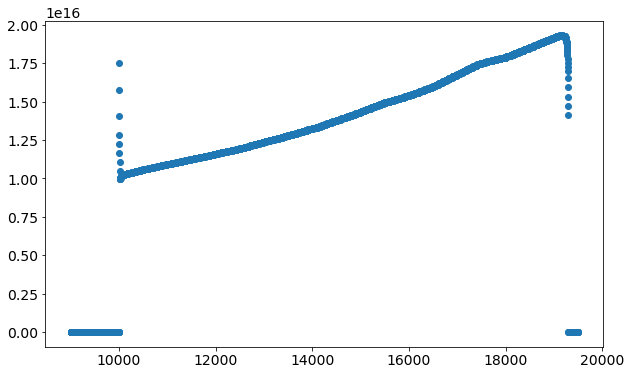

In [36]:
fig = plt.figure()

p1 = fig.add_subplot(111)
#p1.errorbar(sens_cat['WAVELENGTH'],sens_cat['SENSITIVITY'],yerr=sens_cat['ERROR'])
p1.scatter(sens_cat['WAVELENGTH'],sens_cat['SENSITIVITY'])

## Show 2D beam
[top](#Table-of-Contents)

In [ ]:
## Spectrum with lines & noise
#spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
#spectrum_file = '../../../grizli/templates/erb2010.dat'
#erb = np.loadtxt(spectrum_file, unpack=True)
#z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
#import pysynphot as S
#spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
#spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
#spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure(figsize=(14,4))
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    #print(key)
    #beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    #beams[key].beam.compute_model()
    
    gdata = beams[key].grism.data['SCI']*1
    gmodel = beams[key].model
    gcontam = beams[key].contam
    
    print(gdata)
    print(gmodel)
    print(gcontam)
    
    print(np.min(gdata),np.max(gdata))
    print(np.min(gmodel),np.max(gmodel))
    print(np.min(gcontam),np.max(gcontam))
    
    print(gdata.shape)
    print(gmodel.shape)
    print(gcontam.shape)
    
    axl = fig.add_subplot(321+i*2)
    #axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
    #       origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.imshow(beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    
    axr = fig.add_subplot(321+i*2+1)
    #axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
    #           interpolation='Nearest', 
    #           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')

    axr.imshow(beams[key].contam , 
               interpolation='Nearest', 
               origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    #axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    #for ax in [axl, axr]:
    #    beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
    #    beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
    #    if i < 2:
    #        ax.set_xticklabels([])
    #    else:
    #        ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [39]:
def ab2flux(mab,eff_wav):
    c = 2.9979E10 # cm/s
    Ang = 1E-8    # cm
    Jy = 1E-23    # erg/s/cm^2/Hz
    
    # mab = -2.5*np.log10(fnu) - 48.6 
    fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
    flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang

    #print("%.2f AB" % (mab))
    #print("%.2e erg/s/cm^2/Hz" % (fnu))
    #print("%.2e Jy" % (fnu/Jy))
    #print("%.4f uJy" % (fnu/(1e-6*Jy)))
    #print("%.1f nJy" % (fnu/(1e-9*Jy)))
    #print()
    #print("%.2e erg/s/cm^2/Ang" % (flambda))
    #print()
    
    return flambda

In [40]:
# determine flux in Ang for the source in the direct image

mab = phot[phot['NUMBER']==id]['MAG_AUTO'][0]

f_scale = ab2flux(mab,15800.)

## Simple SN calculations based on the spcontetc
[top](#Table-of-Contents)

In [41]:
# Per pix S/N=1
mag_per_pix_w0 = 21.9       # 1.00 um
mag_per_pix_w1 = 21.9       # 1.93 um
mag_per_pix_deepest = 22.7  # 1.34 um

In [42]:
ab2flux(mag_per_pix_w0,10000.)
ab2flux(mag_per_pix_deepest,13400.)

5.042054612716202e-19

/Users/gwalth/data/Roman/grizli/my_roman_sims/Extraction
 col1   col2   col3    col4      col5    col6    col7 
------ ------ ----- ---------- ------- ------- -------
   1.0 0.8657 117.1  5139800.0 21.1989 20.5715 21.3113
1.0581 0.8747 115.9  6604600.0 21.4656 20.8438  21.578
1.1162 0.8837 114.7  7990600.0 21.6669 21.0506 21.7792
1.1744 0.8928 113.6  9035700.0 21.7948 21.1841 21.9072
1.2325 0.9019 112.4  9767600.0 21.8738 21.2686 21.9862
1.2906 0.9111 111.3 10058000.0 21.9001 21.3004 22.0125
1.3487 0.9202 110.2 10102000.0 21.8995 21.3052 22.0118
1.4069 0.9295 109.1  9958700.0 21.8785 21.2897 21.9909
 1.465 0.9387 108.0  9582200.0 21.8313 21.2478 21.9437
1.5231  0.948 106.9  9120700.0 21.7724 21.1942 21.8847
1.5812 0.9574 105.9  8608500.0 21.7043 21.1315 21.8166
1.6394 0.9668 104.9  8131600.0 21.6371 21.0696 21.7495
1.6975 0.9762 103.9  7587000.0 21.5566 20.9943 21.6689
1.7556 0.9857 102.9  7023200.0 21.4675 20.9105 21.5799
1.8137 0.9952 101.9  6384100.0 21.3587 20.8069 21.4711
1.8719 1

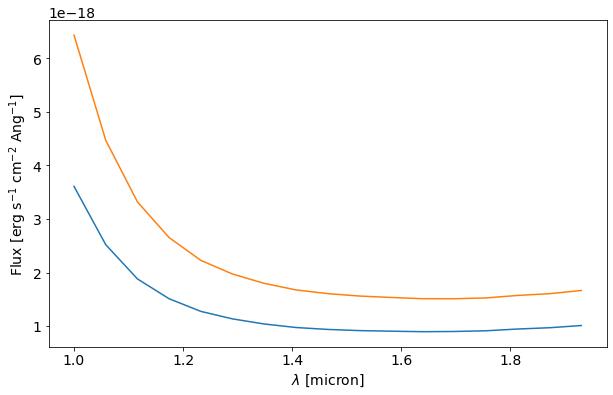

In [43]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1)  
    #p.plot(spcontetc_8n['col1'],f8) 

    

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
    
plt.show()

Roughly estimated from spcontetc (>1.4 micron):

<span style="color:red">5 sigma limit = 1.75e-18 erg/s/cm^2/Ang</span>

<span style="color:red">1 sigma limit = 1.00e-18 erg/s/cm^2/Ang</span>


## Simple SN calculations based on the pzcaletc
[top](#Table-of-Contents)

/Users/gwalth/data/Roman/grizli/my_roman_sims/Extraction
 col1      col2        col3    ...    col10       col11       col12   
------ ----------- ----------- ... ----------- ----------- -----------
   1.0 2.71013e-19 3.55783e-19 ... 1.52512e-18 1.70082e-18 1.87693e-18
1.0332 2.29307e-19 3.00404e-19 ... 1.28054e-18 1.42783e-18 1.57547e-18
1.0664 1.95075e-19  2.5503e-19 ...  1.0811e-18 1.20524e-18  1.3297e-18
1.0996  1.7056e-19 2.22525e-19 ... 9.38094e-19 1.04565e-18 1.15347e-18
1.1329 1.53269e-19 1.99562e-19 ... 8.36668e-19  9.3244e-19 1.02845e-18
1.1661 1.40447e-19 1.82501e-19 ...  7.6096e-19 8.47925e-19 9.35111e-19
1.1993 1.30661e-19 1.69451e-19 ... 7.02705e-19 7.82881e-19 8.63265e-19
1.2325 1.23327e-19 1.59629e-19 ... 6.58392e-19 7.33389e-19 8.08584e-19
1.2657 1.18471e-19 1.53051e-19 ... 6.27861e-19 6.99264e-19 7.70856e-19
1.2989 1.15543e-19 1.48988e-19 ...  6.0792e-19 6.76941e-19 7.46149e-19
   ...         ...         ... ...         ...         ...         ...
1.5979 1.20602e-19 1

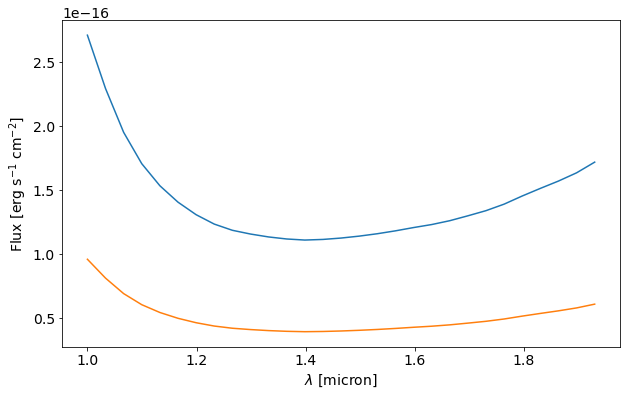

In [44]:
print(os.getcwd())
pzcaletc_1n = Table.read("../etc/pzcaletc_1n.dat",format="ascii")
pzcaletc_8n = Table.read("../etc/pzcaletc_8n.dat",format="ascii")
print(pzcaletc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(2,13):
for n in range(2,3):
    #p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]) # W/m^2
    p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]*1000.) # erg/s/cm^2
    p.plot(pzcaletc_8n['col1'],pzcaletc_8n['col%i' % (n)]*1000.) # erg/s/cm^2

    
#p.legend(fontsize=14)
#p.set_xlim(w1-0.05, w2+0.05)
#p.set_ylim(-1e-21,3e-20)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
    
plt.show()

## 1D Spectral Extraction
[top](#Table-of-Contents)

In [ ]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(6,18))
p1 = fig.add_subplot(311)
p2 = fig.add_subplot(312)
p3 = fig.add_subplot(313)
for i, key in enumerate(beams.keys()):
    print(key)
    print()
    #w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
                                              ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    # normalize to the magnitude in the direct image
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    
    
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    #

    
    # Method 1
    scale = f_scale/np.nansum(f)
    f = f * scale
    e = e * scale
    # Method 2
    #f = (f/np.nanmedian(f)) * f_scale
    # Method 3
    #skysub = f - np.nanmedian(f)
    #f = (skysub/np.nansum(skysub)) * f_scale
    
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    
    
    percent = [1,25,50,75,95,99,99.9]
    for per in percent:
        print("P(%s) = %.2e" % (per,np.nanpercentile(f, per)))
    print()
        
    N = len(f)
        
    print("Chunk  W0  W1  Sum  Mean  Median  STD  Min  Max  S/N")
    
    #chunks = 50. # depends on the width of the line?
    chunks = 70.
    for chunk in np.arange(chunks):
        #print("Chunk = %i" % (chunk+1))
        f_sect = f[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        e_sect = e[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect = w[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect0 = w_sect[0]/1.e4
        w_sect1 = w_sect[-1]/1.e4
        
        print("%3i  %.3f  %.3f  %.2e  %.2e  %.2e  %.2e  %.2e  %.2e  %6.1f" % (chunk+1, w_sect0, w_sect1, np.nansum(f_sect), 
              np.nanmean(f_sect), np.nanmedian(f_sect), np.nanstd(f_sect), np.nanmin(f_sect), 
              np.nanmax(f_sect), np.nansum(f_sect)/np.sqrt(np.nansum(e_sect**2))))
        #print()
        
        
    #print("S/N =",np.nanmax(f)/np.nanstd(f))
    
    m_noi = np.nanmean(e)
    S_N = f/m_noi
    
    
    # plot spectrum
    p1.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    p1.plot([w[0]/1e4,w[-1]/1e4],[m_noi,m_noi], c="g")

    # plot line
    p2.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p2.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    #print(f)
    
    # S/N of line
    p3.plot(w/1.e4, S_N, c="b") # linestyle='steps-mid')
    
    # Line flux and S/N
    print()
    w1 = 1.24
    w2 = 1.26
    #w1 = 1.36
    #w2 = 1.37
    #w1 = 1.48
    #w2 = 1.52
    i1 = np.argmin(np.abs(w/1.e4-w1))
    i2 = np.argmin(np.abs(w/1.e4-w2))
    print(i1,i2)
    
    win = w2 - w1
    i0 = np.argmin(np.abs(w/1.e4-(w1-win)))
    i3 = np.argmin(np.abs(w/1.e4-(w2+win)))
    print(i0,i3)
    print()
    

    dw = w[1] - w[0]
    print(dw)
    
    
    line_flux = np.sum(f[i0:i1])*dw
    line_error = np.sqrt(np.sum((e[i0:i1]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        
    
    line_flux = np.sum(f[i1:i2])*dw
    line_error = np.sqrt(np.sum((e[i1:i2]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    
    
    print(integrate.trapz(f[i1:i2],w[i1:i2]))
    
    print()
    
    line_flux = np.sum(f[i2:i3])*dw
    line_error = np.sqrt(np.sum((e[i2:i3]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        

    
    #y0 = np.nanmin(f)
    #y1 = np.nanmax(f)
    #print(y0,y1)
    
    #z = 1.726
    #lines = [4861.,5007.,6563.]
    #for line in lines:
    #    wobs = line/1e4*(1+z)
    #    p.plot([wobs,wobs],[y0,y1],"--",c="r")
    print()
    print("Size =", len(f))
    print("NaNs = ", np.sum(np.isnan(f)))
    #print(np.nanmedian(f))

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

#p.legend(fontsize=14)
p2.set_xlim(w1-0.05, w2+0.05)
p2.set_ylim(-1e-21,3e-20)
#p2.set_ylim(-1e-21,1e-21)
p2.set_xlabel(r'$\lambda$ [micron]')
p2.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

p3.set_xlim(w1-0.05, w2+0.05)
p3.set_ylim(-20,120.)
p3.set_xlabel(r'$\lambda$ [micron]')
p3.set_ylabel(r'S/N')

In [ ]:
beam = 'beam__%05d.grism.A.fits' % (id)
#new_beam = '{0}_{1:05d}.beams.fits'.format(root, id)
new_beam = beam.replace(".fits","_GLW.fits")

hdu = pyfits.open(beam)
print(hdu[0].header)
hdu.info()


ext = 0
hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
hdu.writeto(new_beam,clobber=True)
hdu.info()

In [ ]:
#mb = multifit.MultiBeam([old_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb.write_master_fits()

####################################################################################
# Limited set of red stellar templates
#tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
#                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
#fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
#                                 spline_correction=True, spline_args={'Rspline':5})
####################################################################################

fwhm = 325 # km/s
t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

#fit = mb.xfit_redshift(templates=t0, zr=[0.65, 1.6], dz=[0.004, 0.0002], fitter='nnls')

###################################################################################
#hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
#                                     size=32, zfit=tfit, diff=True)

In [ ]:
print(fit.keys())

## Velocity resolution
[top](#Table-of-Contents)

In [ ]:
# https://wfirst.ipac.caltech.edu/sims/Param_db.html#wfi_grism
# R = 461*wav # wav in microns

c = 3e5 # km/s

# R = wav/delta_wav
# u = delta_wav/wav*c
# u = c/R

u = lambda wav: c/(461*wav)

winc = 0.25
w = np.arange(1.0,2.0+winc,winc)
for w0 in w:
    print("%.2f km/s (%.2f micron)" % (u(w0),w0))


## Fit redshift to source
[top](#Table-of-Contents)

In [ ]:
fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

## Display Redshift Fit
[top](#Table-of-Contents)

In [ ]:
display_grizli(root, id, w0=1.0, w1=2.0, labels=1)

## Parallel Tests
[top](#Table-of-Contents)

In [ ]:
import multiprocessing as mp
import time

import numpy as np
#from time import time

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
mp.cpu_count()

In [ ]:
t0 = time.time()
results = [howmany_within_range(row, 4, 8) for row in data]
t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

In [ ]:
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

## Parallel Redshift Fitting Tests
[top](#Table-of-Contents)

In [ ]:

#def fit_redshift_parallel(id, grismflt, temp0, temp1, fwhm, root):
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        
    
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

#for id in phot['NUMBER'][:3]:

# This breaks if there is a magnitude cut!!!
#Narr = phot['NUMBER']

#t0 = time.time()
Narr = phot['NUMBER'][:5]
#[fit_redshift_parallel(id, Roman, temp0, temp1, fwhm, root) for id in Narr]
#t1 = time.time()
#print(t1-t0,"seconds")


## version 1 
#t0 = time.time()
## Step 1: Init multiprocessing.Pool()
#pool = mp.Pool(mp.cpu_count())

## Step 2: `pool.apply` the `fit_redshift_parallel()`
##[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

#[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

## Step 3: Don't forget to close
#pool.close()
#t1 = time.time()
#print(t1-t0,"seconds")


# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        

In [ ]:
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

In [ ]:
t0 = time.time()
# This breaks if there is a magnitude cut!!!
Narr = phot['NUMBER'][:40]
[fit_redshift_parallel(id, fwhm, root) for id in Narr]
t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
Narr = phot['NUMBER'][:40]

# version 1 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `fit_redshift_parallel()`
#[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

# Step 3: Don't forget to close
pool.close()
t1 = time.time()
print(t1-t0,"seconds")



In [ ]:
print(results)

In [ ]:
Narr = phot['NUMBER'][:40]

# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")
